In [1]:
import obspy
from obspy.taup import TauPyModel

from multiprocessing import Pool
from obspy import read,UTCDateTime,Trace,read_inventory,read_events
from obspy.io.sac.sactrace import SACTrace
from obspy.imaging.beachball import beachball,beach
from obspy.clients.fdsn import Client
from obspy.signal.trigger import recursive_sta_lta

import os
from glob import glob
import numpy as np
from collections import defaultdict
import pandas as pd
from scipy import signal
import subprocess
from sklearn import preprocessing
import geopy.distance


#para plotar as figuras
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.transforms import offset_copy
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.cm as cm
from matplotlib.dates import YearLocator, MonthLocator, DayLocator, HourLocator, MinuteLocator, SecondLocator, DateFormatter
from matplotlib.ticker import MultipleLocator, FormatStrFormatter,FixedLocator,StrMethodFormatter
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec

from datetime import datetime,timedelta,date
from tqdm import tqdm

from shapely.geometry.polygon import LinearRing
from matplotlib.patches import Rectangle

import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter,LatitudeFormatter
import requests
import csv
import xml.etree.ElementTree as ET
import ast

# INPUT DATA

In [2]:
EVENT_GLIDER = '/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/OUTPUT/EVENTS_GLIDERS/'
EVENT_RSBR = '/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/OUTPUT/DATA_EVENTS/'
QUAKEXML_FOLDER = '/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/OUTPUT/EVENTS/'
FOLDER_OUTPUT = '/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/OUTPUT/'
TABLE_EVENTS_RECORDED = '/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/OUTPUT/FIGURAS/STATISTICS/table_events_selected.csv'
MODEL_CAKE = '/home/sysop/dados_posdoc/GLIDER_PETROBRAS/EARTH_MODEL_AREA/model_ak135_SOFAR.nd'


In [3]:
EVENT_GLIDER = '/home/sysop/dados_posdoc/GLIDER_PETROBRAS/OUTPUT/EVENTS_GLIDERS/'
EVENT_RSBR = '/home/sysop/dados_posdoc/GLIDER_PETROBRAS/DATA_EVENTS/'
QUAKEXML_FOLDER = '/home/sysop/dados_posdoc/GLIDER_PETROBRAS/OUTPUT/EVENTS/'
FOLDER_OUTPUT = '/home/sysop/dados_posdoc/GLIDER_PETROBRAS/OUTPUT/'
TABLE_EVENTS_RECORDED = '/home/sysop/dados_posdoc/GLIDER_PETROBRAS/OUTPUT/FIGURAS/STATISTICS/table_events_selected.csv'
MODEL_CAKE = '/home/sysop/dados_posdoc/GLIDER_PETROBRAS/EARTH_MODEL_AREA/model_ak135_SOFAR.nd'


In [4]:
df = pd.read_csv(TABLE_EVENTS_RECORDED)

In [5]:
df_events = obspy.read_events(glob(QUAKEXML_FOLDER+'CMTSOLUTIONS*')[0])

In [6]:
df.head(2)

Unnamed: 0            filename_mseed name_glider Phase          ev_ID  \
0           0  GL.G170E..HHH.D.2017.165       G170E     P  201706140729A   
1           1  GL.G170B..HHH.D.2017.105       G170B     P  201704150819A   

                       ev_time  ev_lat  ev_long  ev_depth   distance  ...  \
0  2017-06-14T07:29:07.900000Z   14.92   -92.17      72.7  62.215434  ...   
1  2017-04-15T08:19:48.300000Z  -23.20   -67.92     164.2  21.404124  ...   

                                       lat_dive_info  \
0  [-26.007275, -26.007362, -26.007454, -26.00754...   
1  [-25.06429, -25.064194, -25.064098, -25.064003...   

                                       lon_dive_info  \
0  [-43.86434, -43.8644, -43.864456, -43.86451, -...   
1  [-44.576466, -44.57627, -44.576073, -44.575874...   

                                     depth_dive_info  \
0  [-1.85, -4.1899996, -12.424999, -19.012001, -2...   
1  [-348.46002, -355.0655, -361.505, -367.351, -3...   

                     srn_per_band  \
0  [1.7, 1.0, 0.9, 1.0, 1.6, 3.7]   
1  [1.8, 1.0, 1.0, 1.1, 4.2, 4.7]   

                                sta_lta_max_per_band  \
0  [6.505769784624672, 3.2188930134934375, 2.8289...   
1  [4.081472549707962, 1.6518214055124516, 1.9778...   

                                      noise_per_band  \
0  [-40.090801396433974, -49.12575636090834, -43....   
1  [-41.64898035233148, -48.86660614126883, -44.2...   

   automatic_event_detection  automatic_time_residual  year ev_depth_round  
0                       True                    -3.80  2017           75.0  
1                       True                    -3.42  2017          175.0  

[2 rows x 30 columns]

In [21]:
ev_local = []
for i in df.iterrows():
    for j in df_events:
        if i[1]['ev_ID'] == j.event_descriptions[0].text:
            ev_local.append(j.origins[0].region.title())

In [22]:
df['local'] = ev_local

In [23]:
df['magnitude']


0     6.95
1     6.27
2     6.33
3     6.69
4     7.19
5     6.00
6     7.47
7     7.48
8     7.27
9     6.38
10    7.47
11    7.48
12    6.38
13    6.00
14    7.19
15    7.80
Name: magnitude, dtype: float64

In [24]:
SNR_max_lst = []
STA_LTA_max_lst = []

for i in df.iterrows():
    SNR_max_lst.append(max(ast.literal_eval((i[1]['srn_per_band']))))
    STA_LTA_max_lst.append(max(ast.literal_eval((i[1]['sta_lta_max_per_band']))))

In [25]:
df['SNR_max'] = SNR_max_lst
df['STA_LTA_max'] = STA_LTA_max_lst

In [40]:
# Function to classify earthquake depth
def class_dep(ev_depth):
    if ev_depth <= 70:
        return 'S'
    elif 70 < ev_depth <= 350:
        return 'I'
    else:
        return 'D'

In [60]:
# Aplicar a função a cada linha da coluna 'profundidade'
df['depth_class'] = df['ev_depth'].apply(class_dep)

In [61]:
df_sel = df[['ev_ID','Phase','magnitude','ev_depth','depth_class','distance','SNR_max','STA_LTA_max','automatic_time_residual']]

In [62]:
df_sel.sort_values('distance')

ev_ID  Phase  magnitude  ev_depth depth_class    distance  \
1   201704150819A      P       6.27     164.2           I   21.404124   
2   201611041620A      P       6.33      96.2           I   25.685713   
0   201706140729A      P       6.95      72.7           I   62.215434   
15  201612081738A  PKIKP       7.80      45.5           S  137.045770   
5   201907111708A    PKP       6.00     493.1           D  146.578300   
13  201907111708A  PKIKP       6.00     493.1           D  146.578300   
6   201802251744A    PKP       7.47      12.0           S  148.417358   
10  201802251744A  PKIKP       7.47      12.0           S  148.417358   
9   201902171435A    PKP       6.38     372.2           D  148.568806   
12  201902171435A  PKIKP       6.38     372.2           D  148.568806   
3   201810131110A    PKP       6.69     473.4           D  148.859548   
7   202003250249A    PKP       7.48      52.6           S  150.584355   
11  202003250249A  PKIKP       7.48      52.6           S  150.584355   
4   201907140910A    PKP       7.19      12.0           S  152.510997   
14  201907140910A  PKIKP       7.19      12.0           S  152.510997   
8   201701100613A    PKP       7.27     621.5           D  155.136715   

    SNR_max  STA_LTA_max  automatic_time_residual  
1       4.7     8.295845                    -3.42  
2       1.9     7.795196                     1.87  
0       3.7     9.239168                    -3.80  
15      2.0     4.724066                    -7.75  
5       3.2     9.294083                     1.32  
13      3.1     9.244477                     3.82  
6       3.0     6.016228                    -3.49  
10      3.0     5.966364                     0.01  
9       7.5    11.423078                    -2.27  
12      5.3    11.425806                     1.83  
3       1.7     6.436614                     2.11  
7       3.2     5.041949                    -7.65  
11      2.6     5.147985                    -2.16  
4       1.9     5.357043                    -0.24  
14      1.6     3.529356                     6.65  
8       2.4     6.834133                     2.39

In [63]:
df_sel.sort_values('distance').style.format(precision=2).to_latex()

'\\begin{tabular}{lllrrlrrrr}\n & ev_ID & Phase & magnitude & ev_depth & depth_class & distance & SNR_max & STA_LTA_max & automatic_time_residual \\\\\n1 & 201704150819A & P & 6.27 & 164.20 & I & 21.40 & 4.70 & 8.30 & -3.42 \\\\\n2 & 201611041620A & P & 6.33 & 96.20 & I & 25.69 & 1.90 & 7.80 & 1.87 \\\\\n0 & 201706140729A & P & 6.95 & 72.70 & I & 62.22 & 3.70 & 9.24 & -3.80 \\\\\n15 & 201612081738A & PKIKP & 7.80 & 45.50 & S & 137.05 & 2.00 & 4.72 & -7.75 \\\\\n5 & 201907111708A & PKP & 6.00 & 493.10 & D & 146.58 & 3.20 & 9.29 & 1.32 \\\\\n13 & 201907111708A & PKIKP & 6.00 & 493.10 & D & 146.58 & 3.10 & 9.24 & 3.82 \\\\\n6 & 201802251744A & PKP & 7.47 & 12.00 & S & 148.42 & 3.00 & 6.02 & -3.49 \\\\\n10 & 201802251744A & PKIKP & 7.47 & 12.00 & S & 148.42 & 3.00 & 5.97 & 0.01 \\\\\n9 & 201902171435A & PKP & 6.38 & 372.20 & D & 148.57 & 7.50 & 11.42 & -2.27 \\\\\n12 & 201902171435A & PKIKP & 6.38 & 372.20 & D & 148.57 & 5.30 & 11.43 & 1.83 \\\\\n3 & 201810131110A & PKP & 6.69 & 473.40 & D

In [64]:
df_sel.sort_values('distance').to_latex(index=False,formatters={"name": str.upper},float_format="{:.2f}".format)

'\\begin{tabular}{llrrlrrrr}\n\\toprule\nev_ID & Phase & magnitude & ev_depth & depth_class & distance & SNR_max & STA_LTA_max & automatic_time_residual \\\\\n\\midrule\n201704150819A & P & 6.27 & 164.20 & I & 21.40 & 4.70 & 8.30 & -3.42 \\\\\n201611041620A & P & 6.33 & 96.20 & I & 25.69 & 1.90 & 7.80 & 1.87 \\\\\n201706140729A & P & 6.95 & 72.70 & I & 62.22 & 3.70 & 9.24 & -3.80 \\\\\n201612081738A & PKIKP & 7.80 & 45.50 & S & 137.05 & 2.00 & 4.72 & -7.75 \\\\\n201907111708A & PKP & 6.00 & 493.10 & D & 146.58 & 3.20 & 9.29 & 1.32 \\\\\n201907111708A & PKIKP & 6.00 & 493.10 & D & 146.58 & 3.10 & 9.24 & 3.82 \\\\\n201802251744A & PKP & 7.47 & 12.00 & S & 148.42 & 3.00 & 6.02 & -3.49 \\\\\n201802251744A & PKIKP & 7.47 & 12.00 & S & 148.42 & 3.00 & 5.97 & 0.01 \\\\\n201902171435A & PKP & 6.38 & 372.20 & D & 148.57 & 7.50 & 11.42 & -2.27 \\\\\n201902171435A & PKIKP & 6.38 & 372.20 & D & 148.57 & 5.30 & 11.43 & 1.83 \\\\\n201810131110A & PKP & 6.69 & 473.40 & D & 148.86 & 1.70 & 6.44 & 2.11

In [65]:
df_sel_D_I = df_sel[df_sel['depth_class'] == 'I']

In [66]:
df_sel_D_I[df_sel_D_I['magnitude'] > 7].sort_values('STA_LTA_max')

Empty DataFrame
Columns: [ev_ID, Phase, magnitude, ev_depth, depth_class, distance, SNR_max, STA_LTA_max, automatic_time_residual]
Index: []

In [73]:
cat = obspy.read_events(QUAKEXML_FOLDER+'CMTSOLUTIONS*')
#cat


2021-12-29T18:25:51.700000Z

In [89]:
i[1]['ev_ID']

'201612081738A'

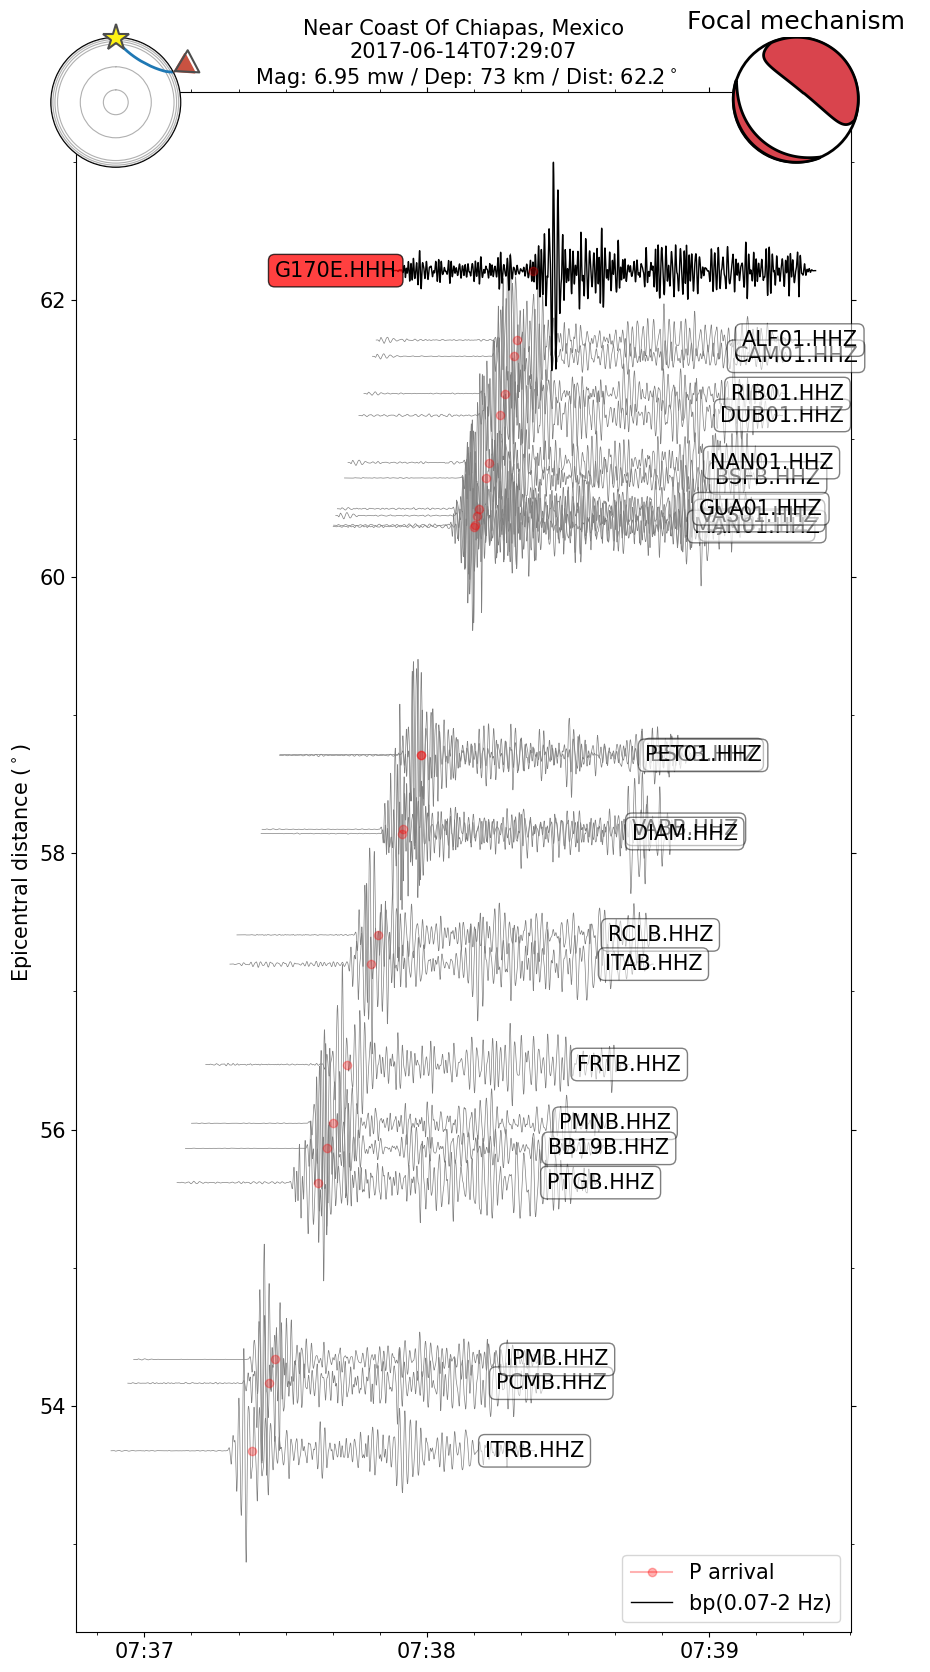

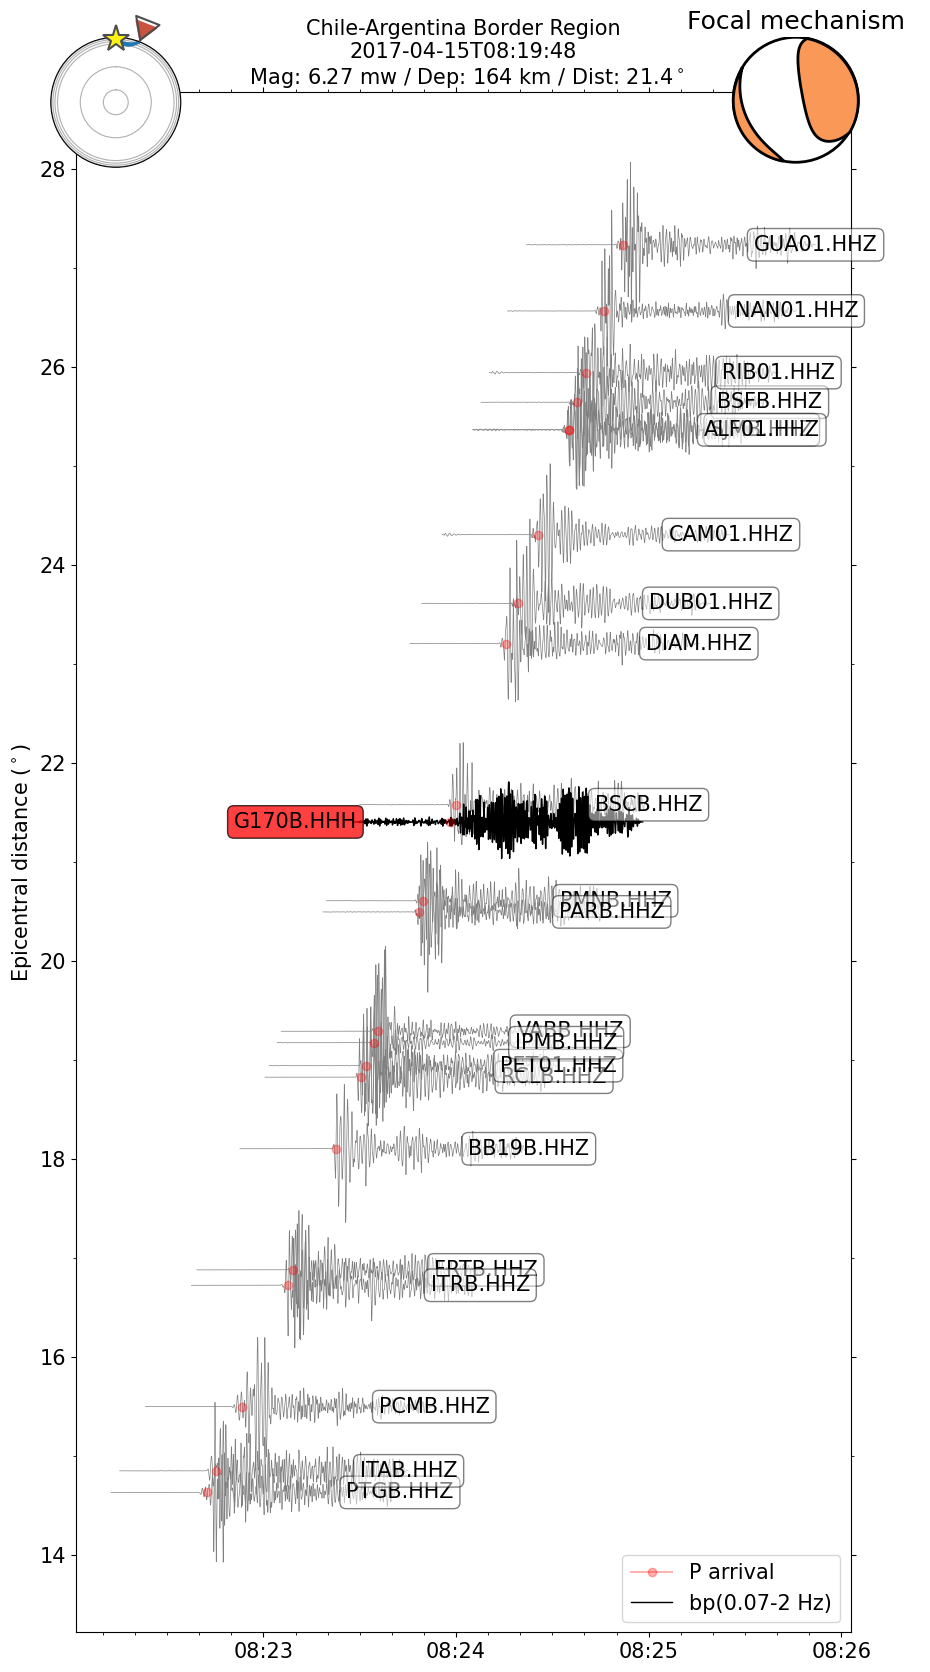

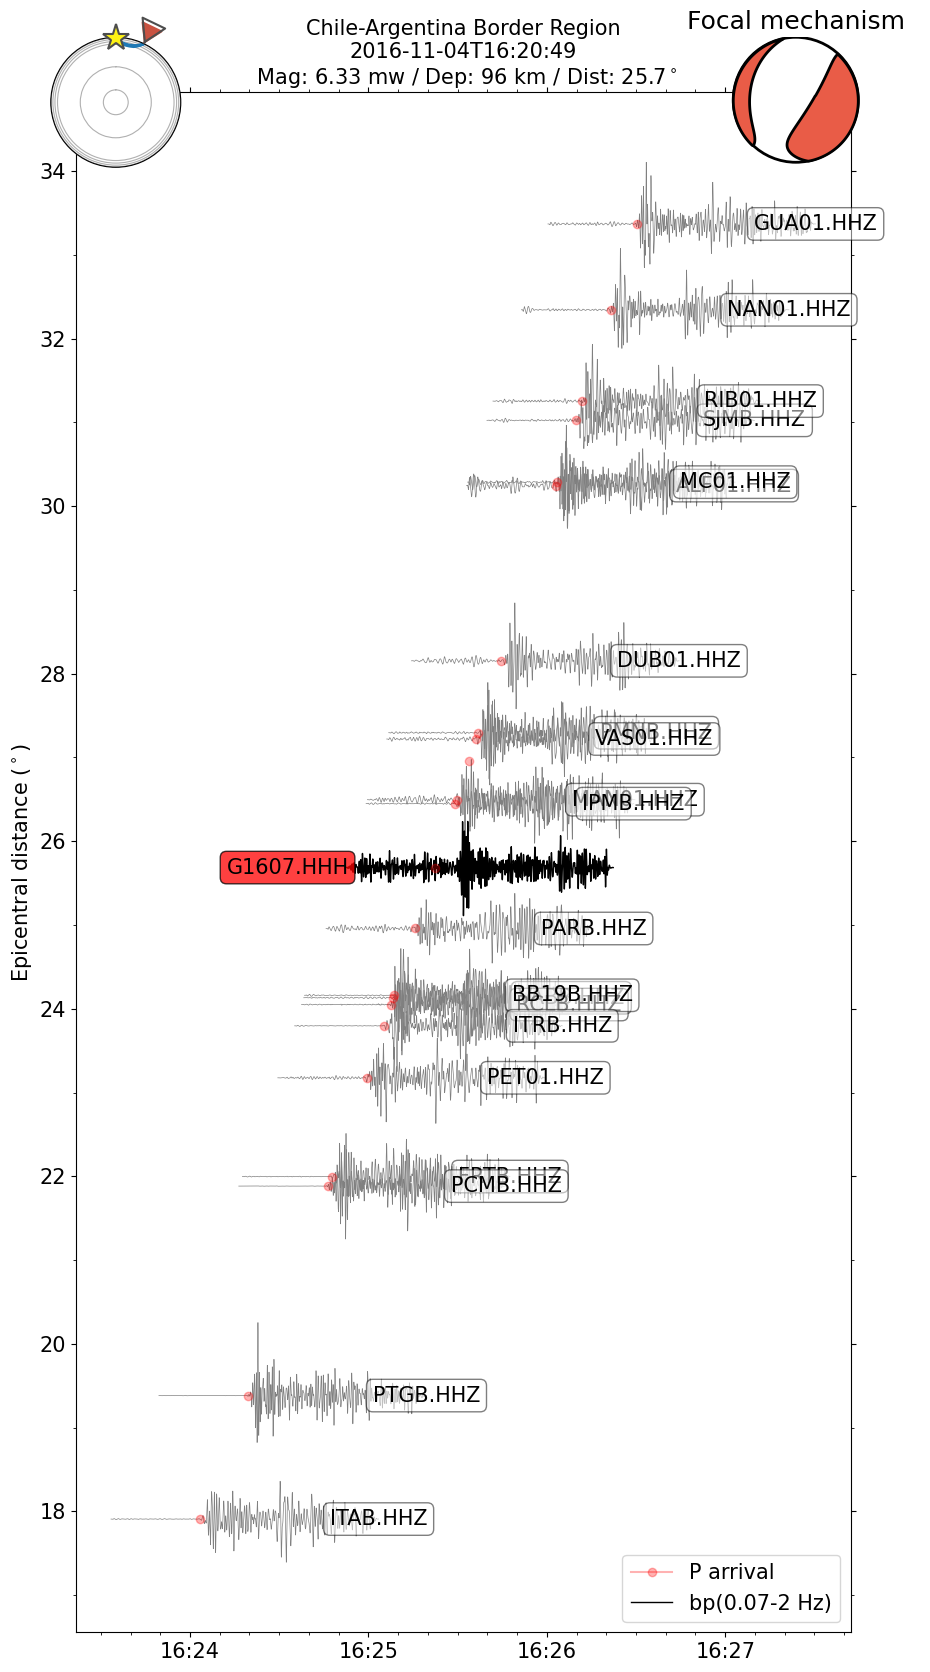

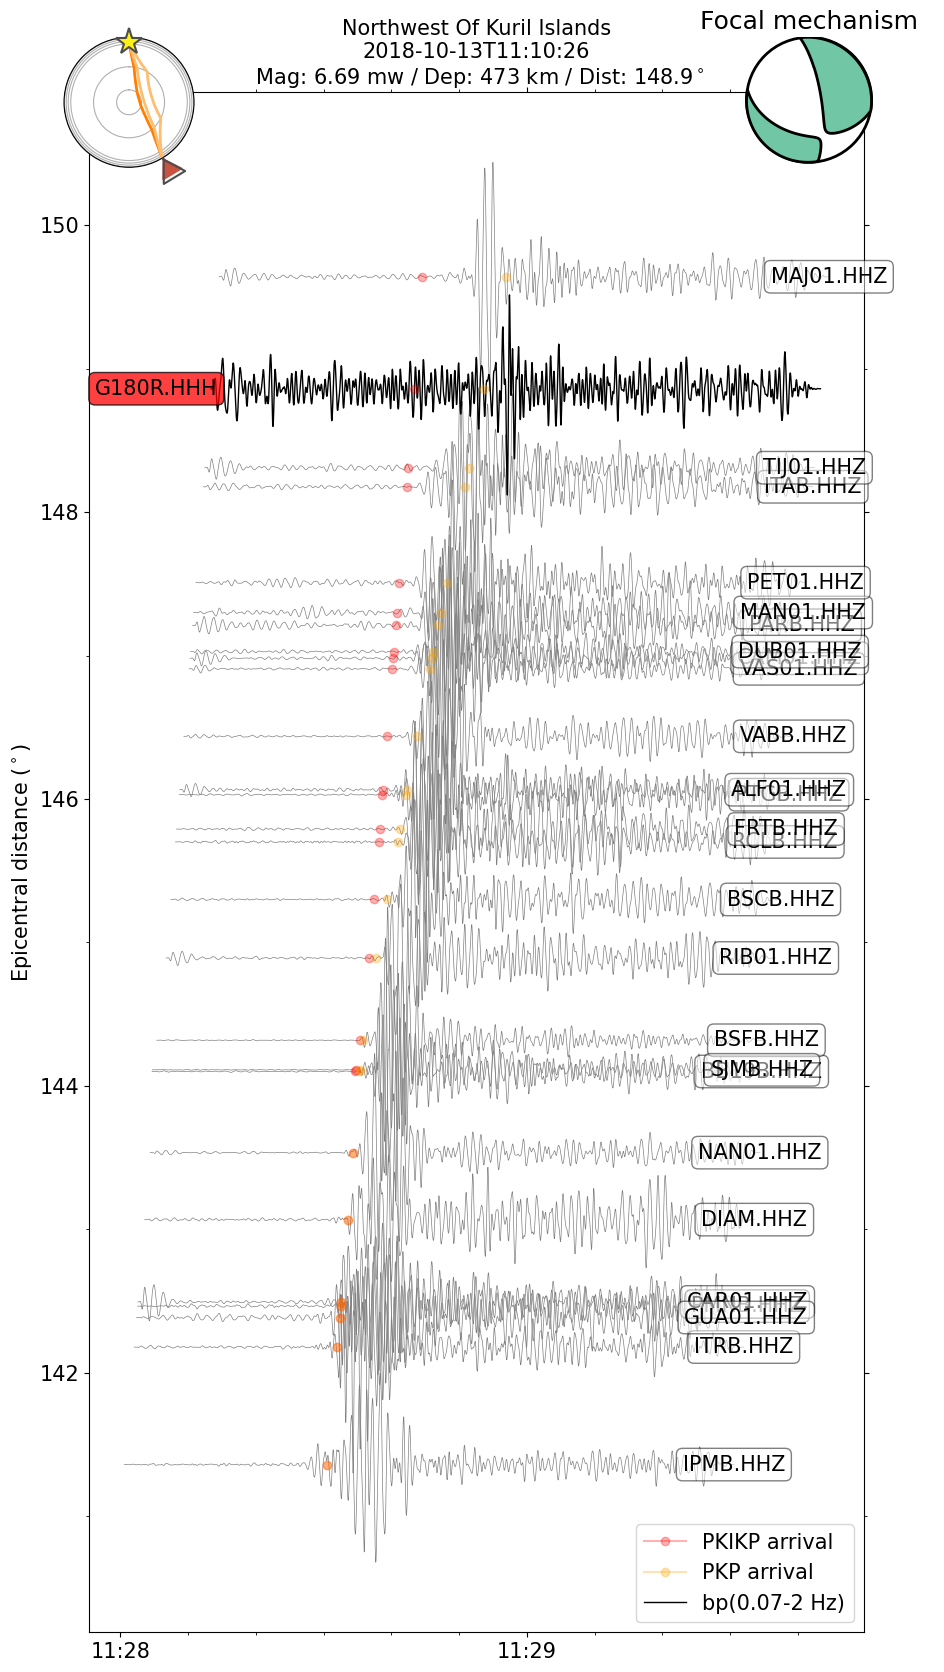

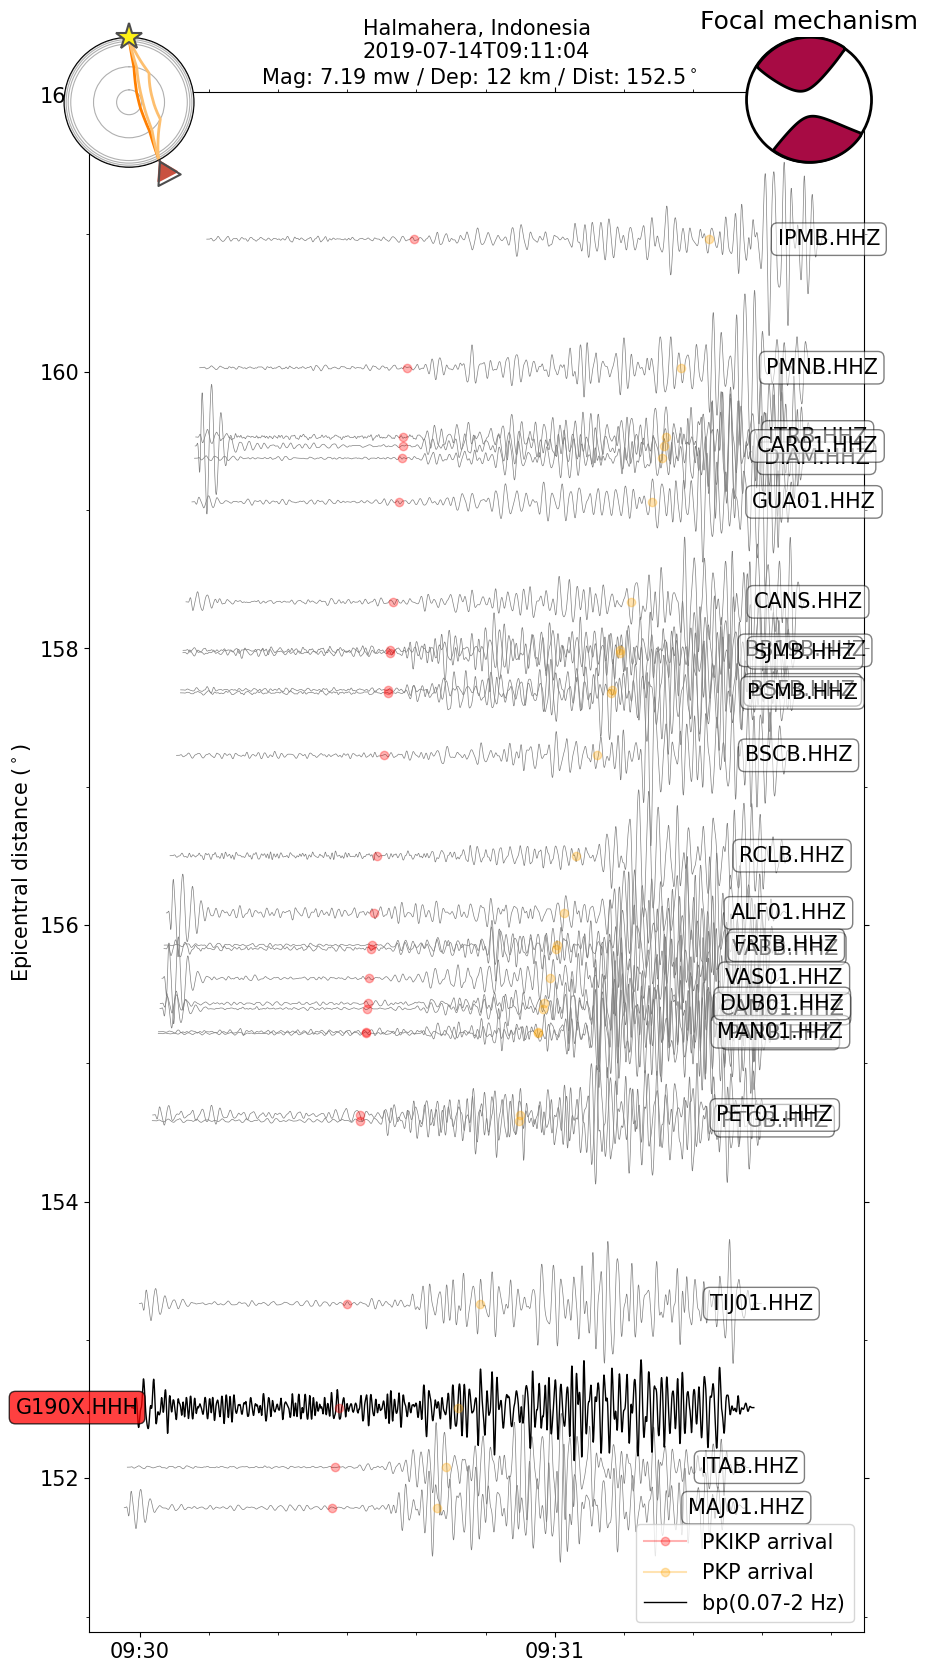

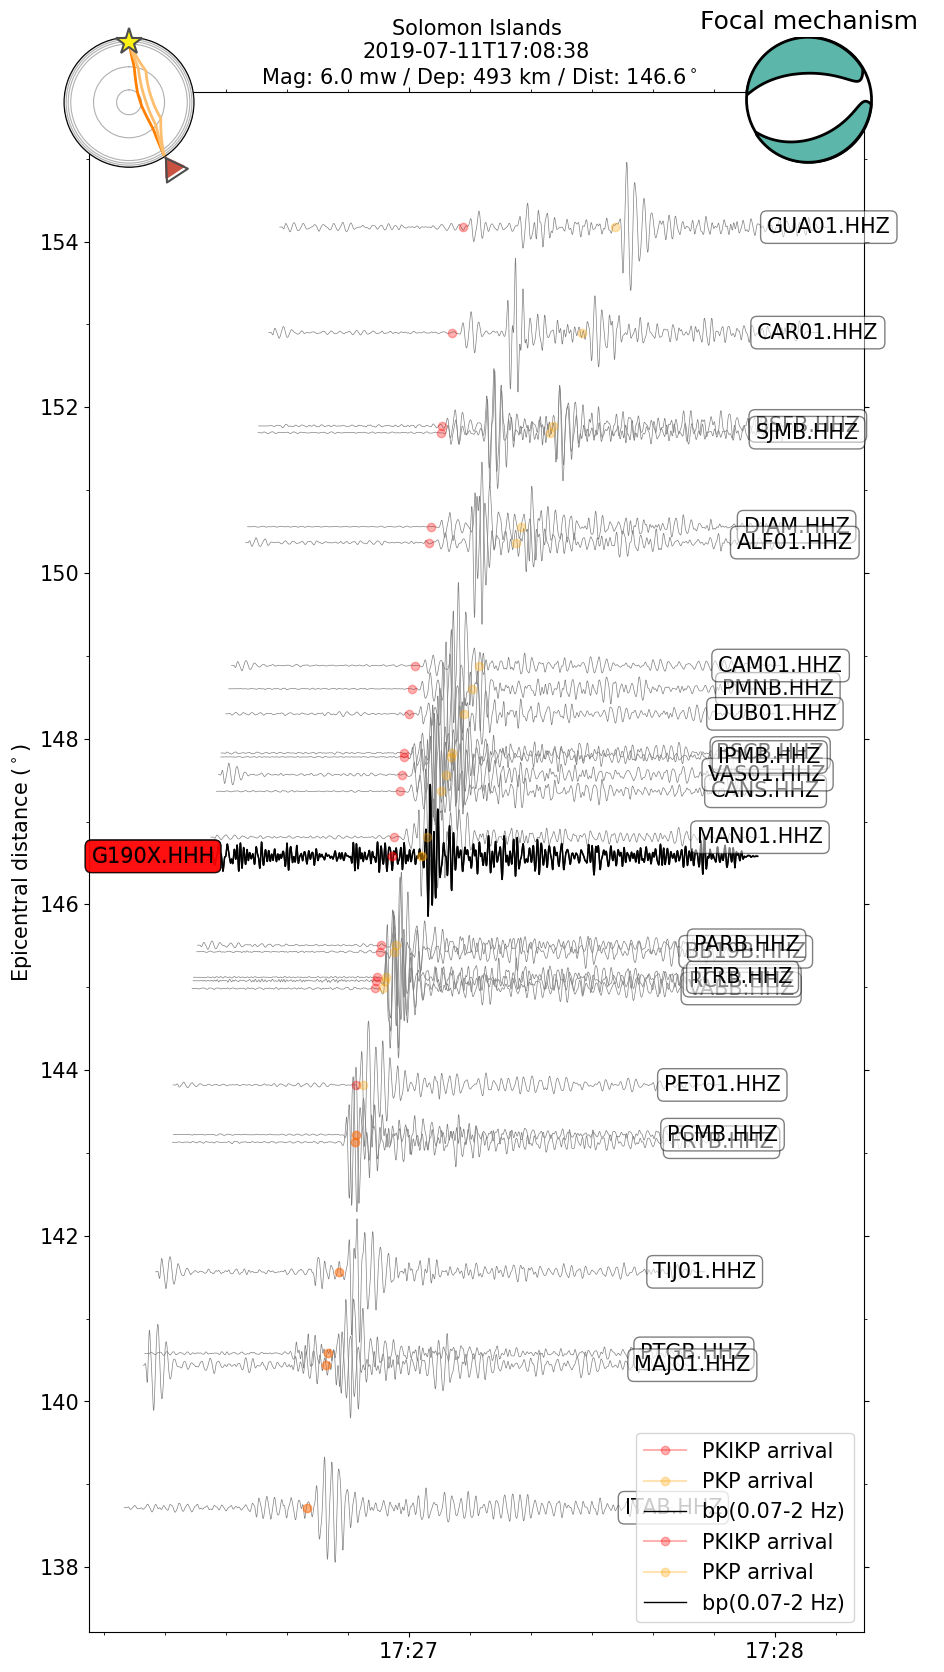

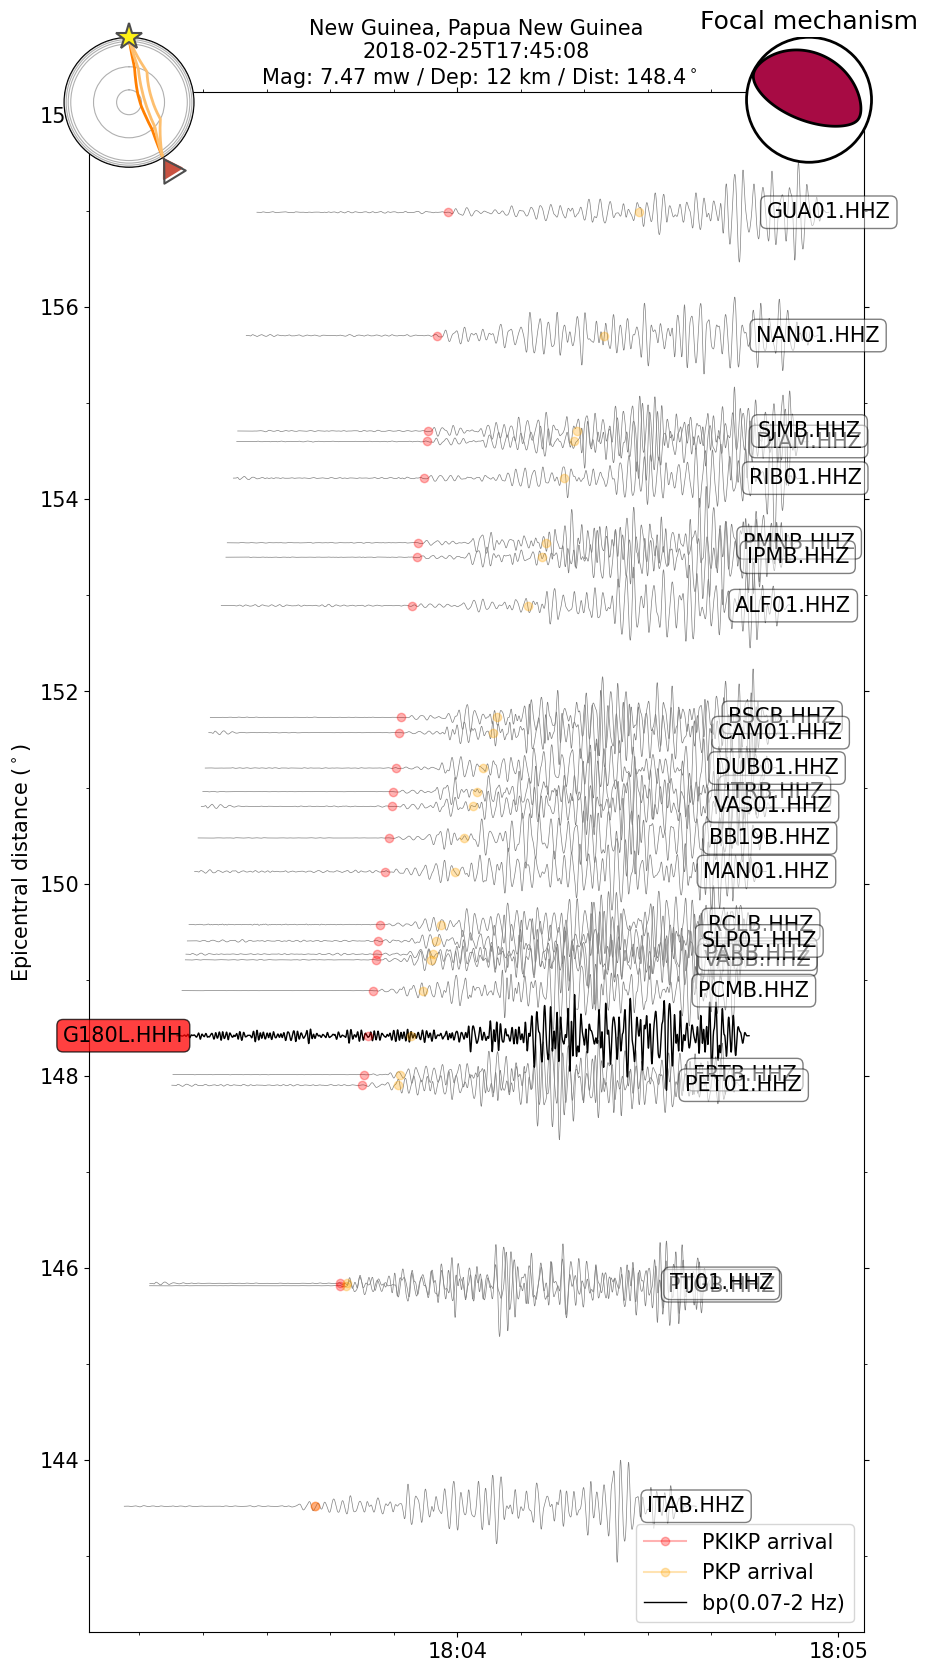

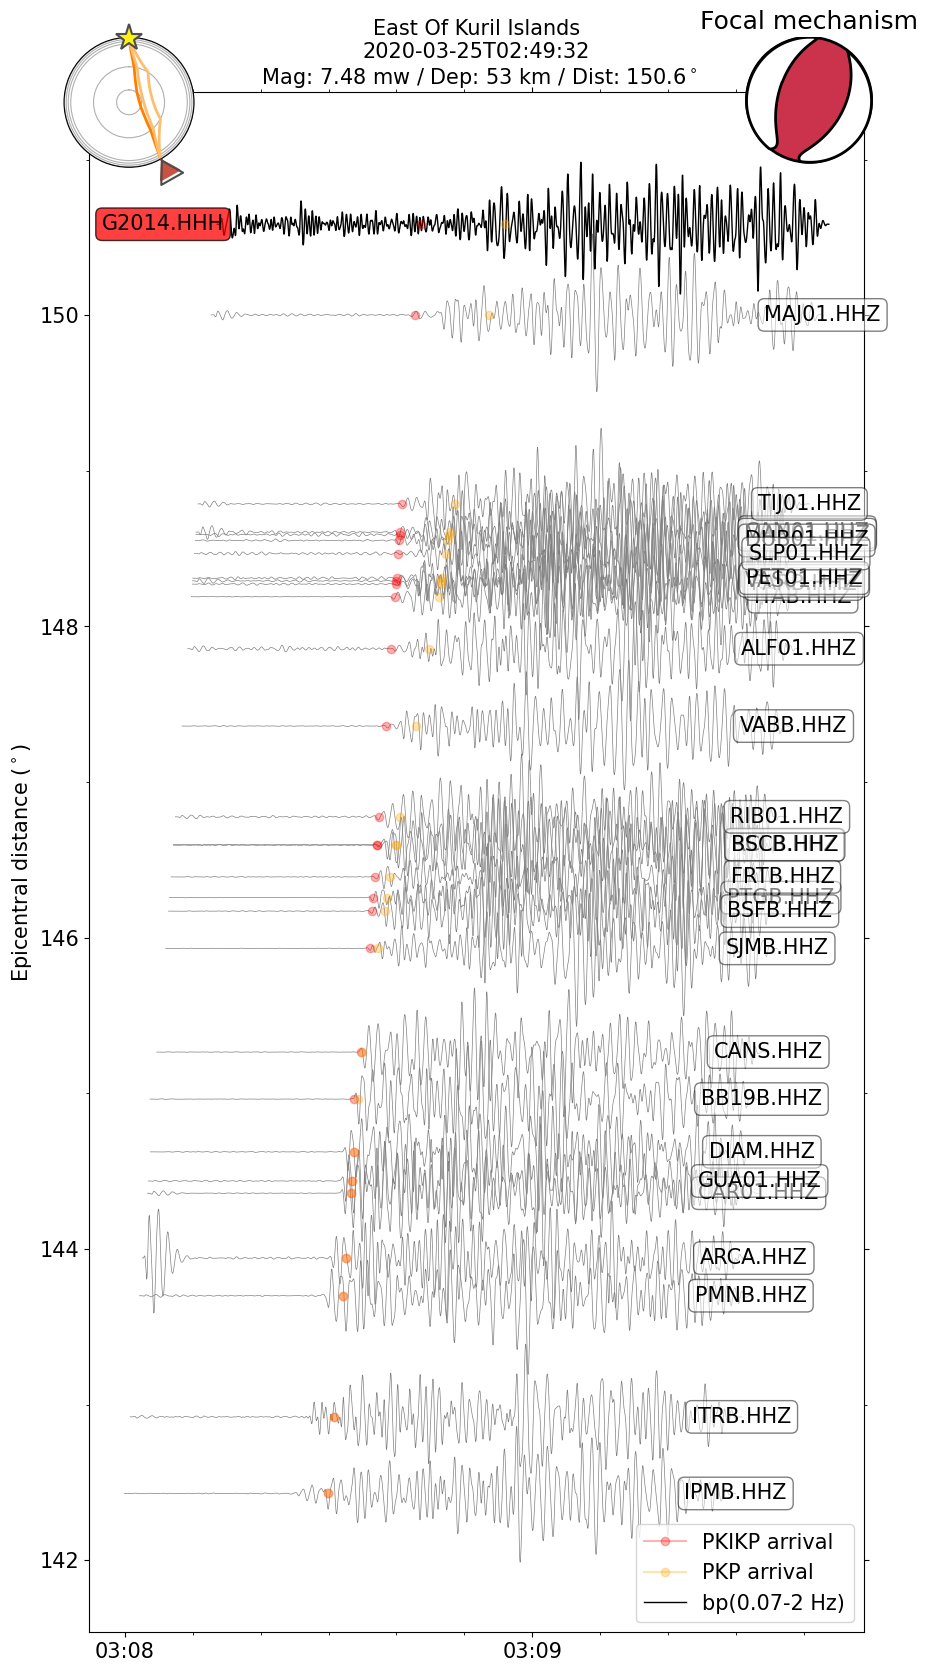

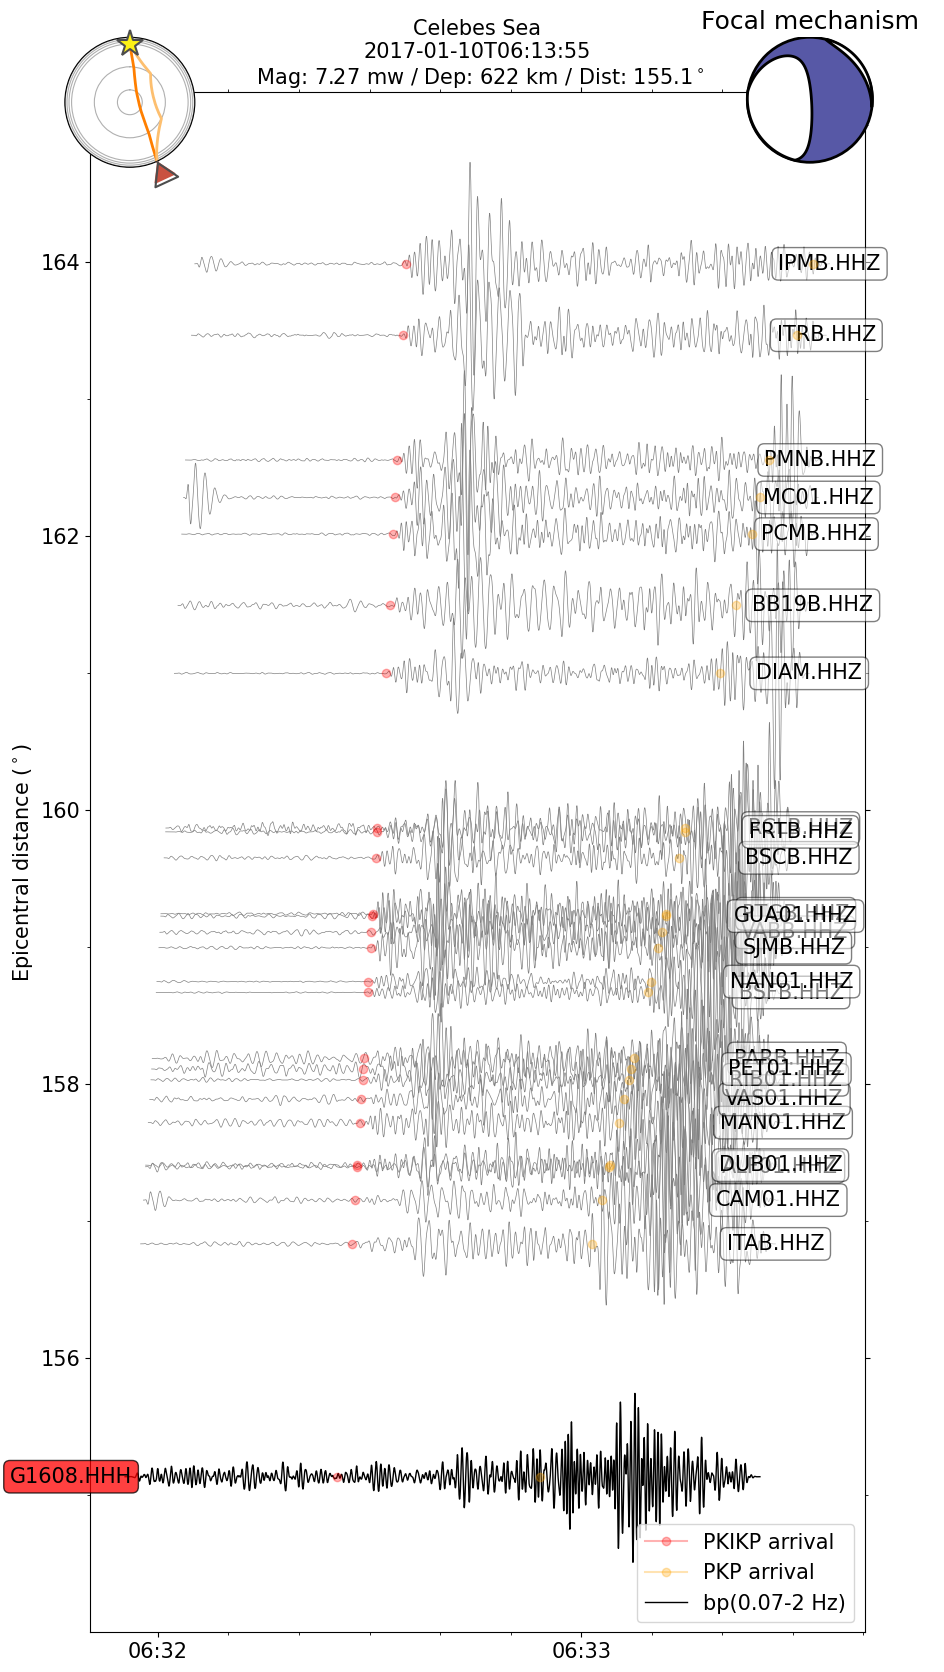

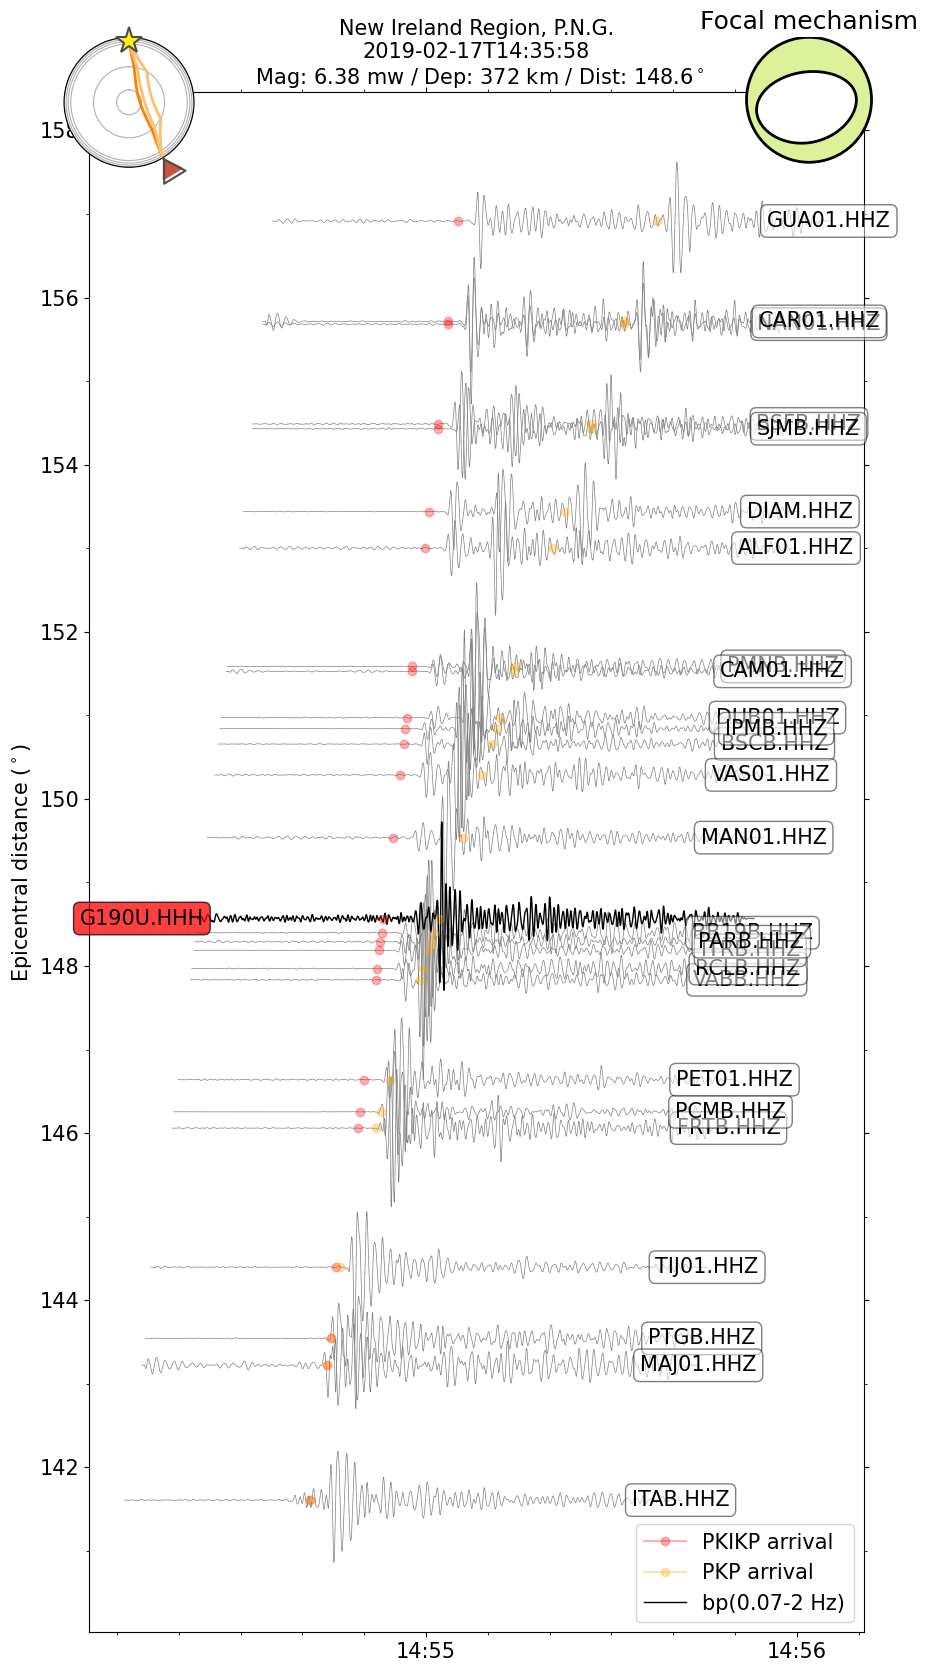

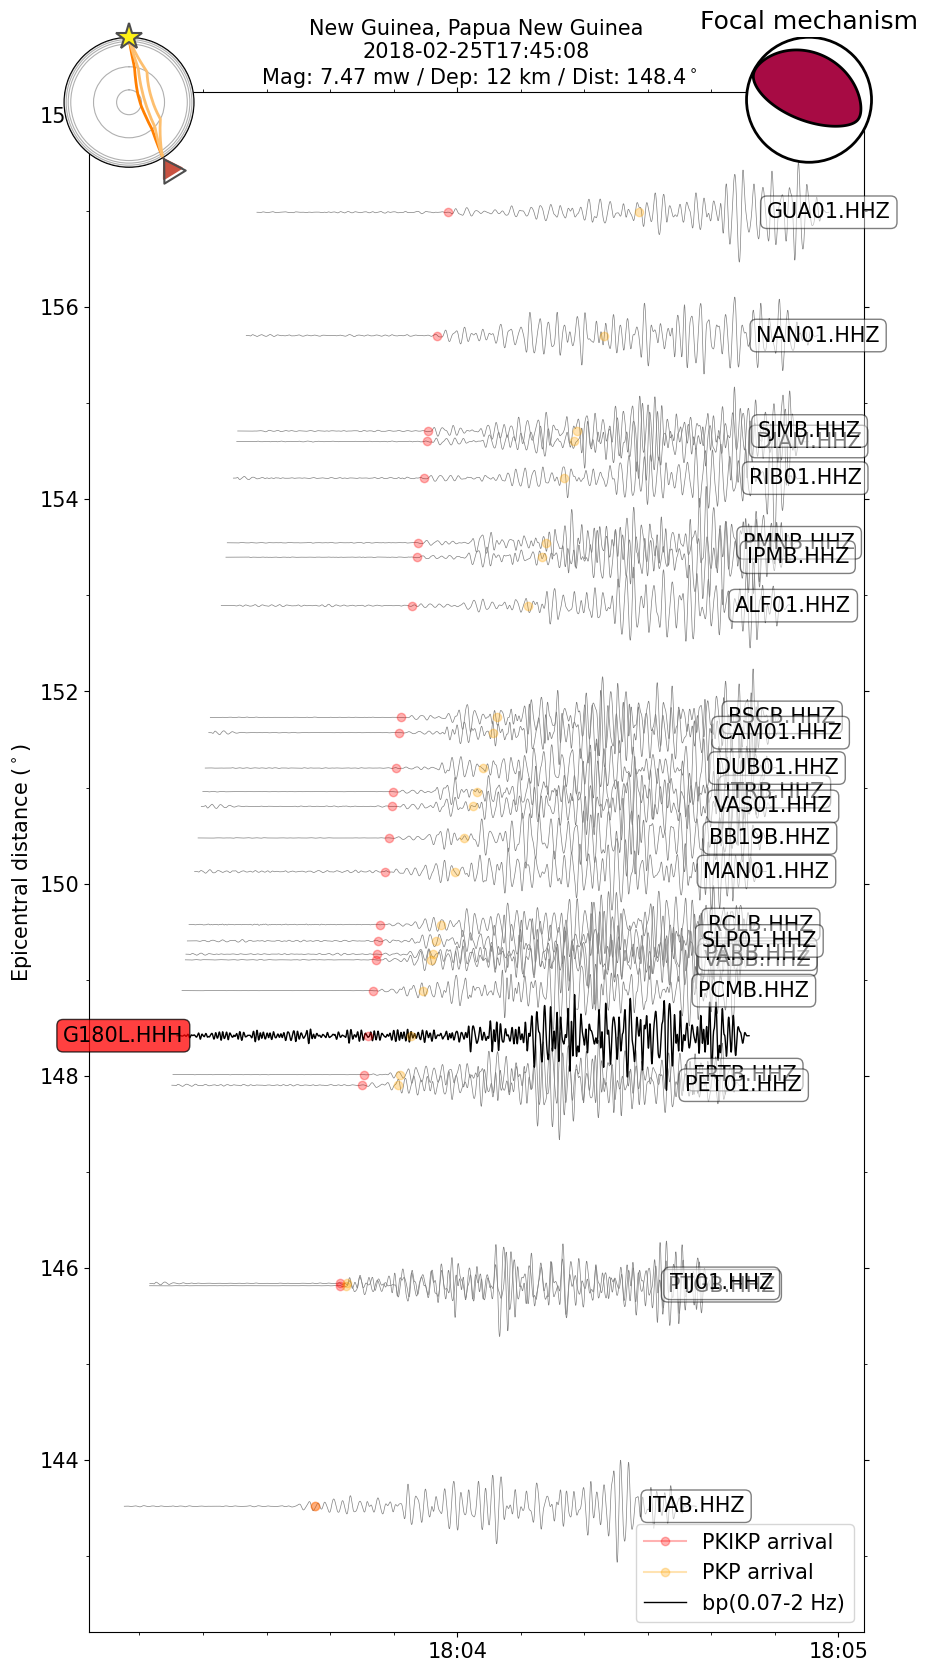

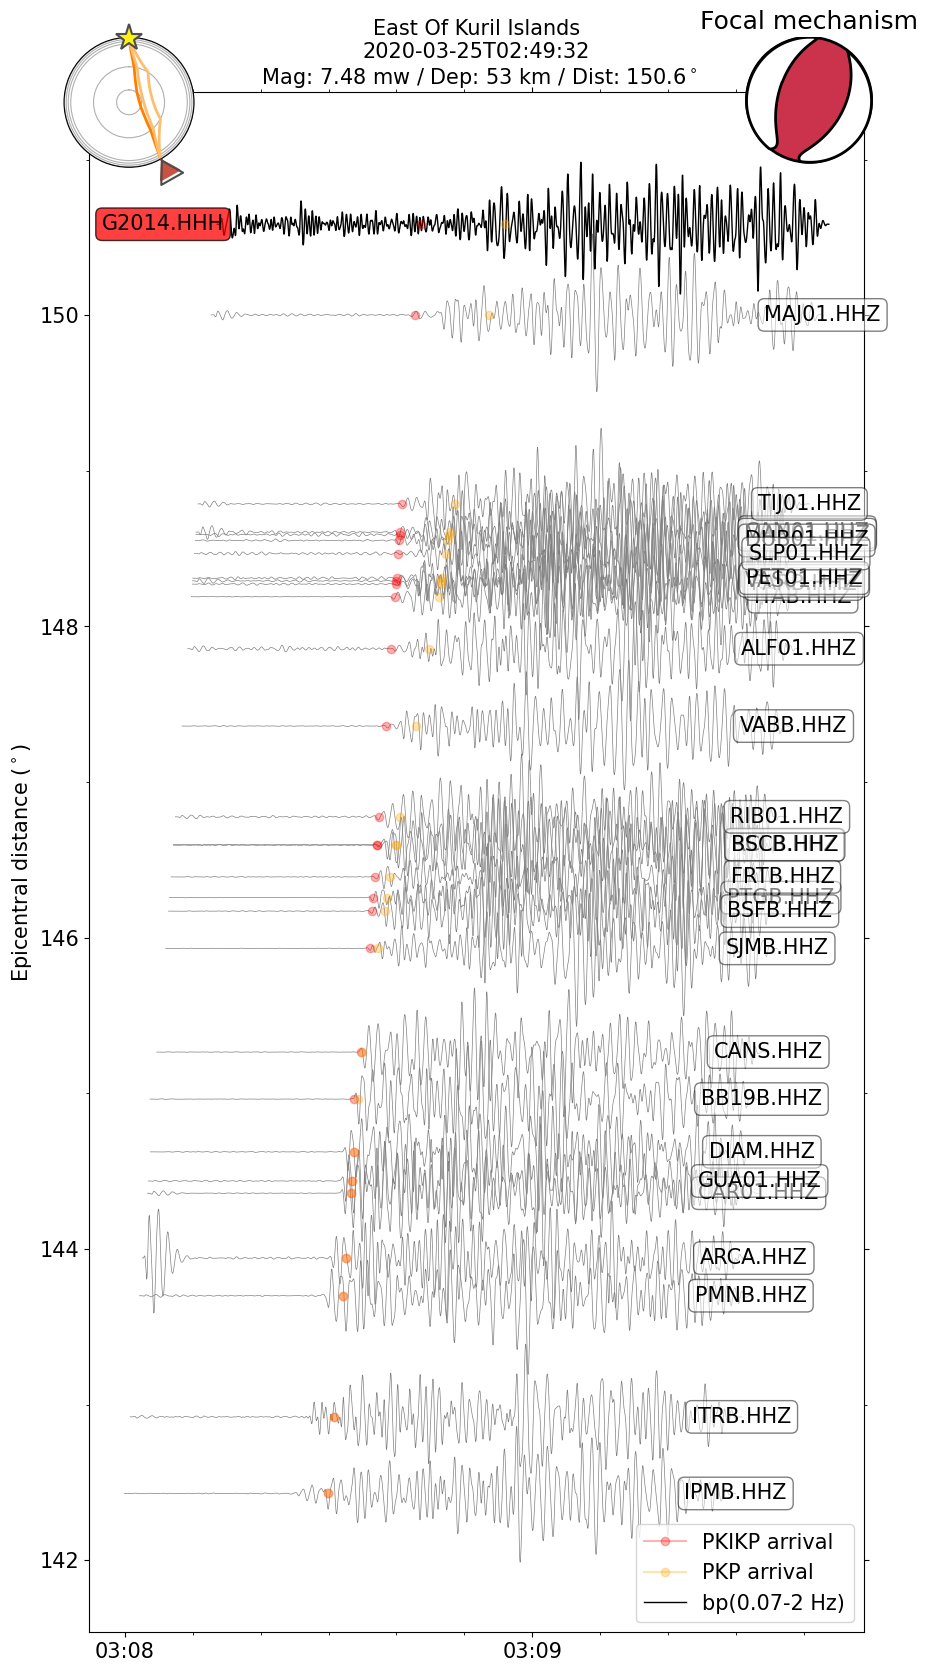

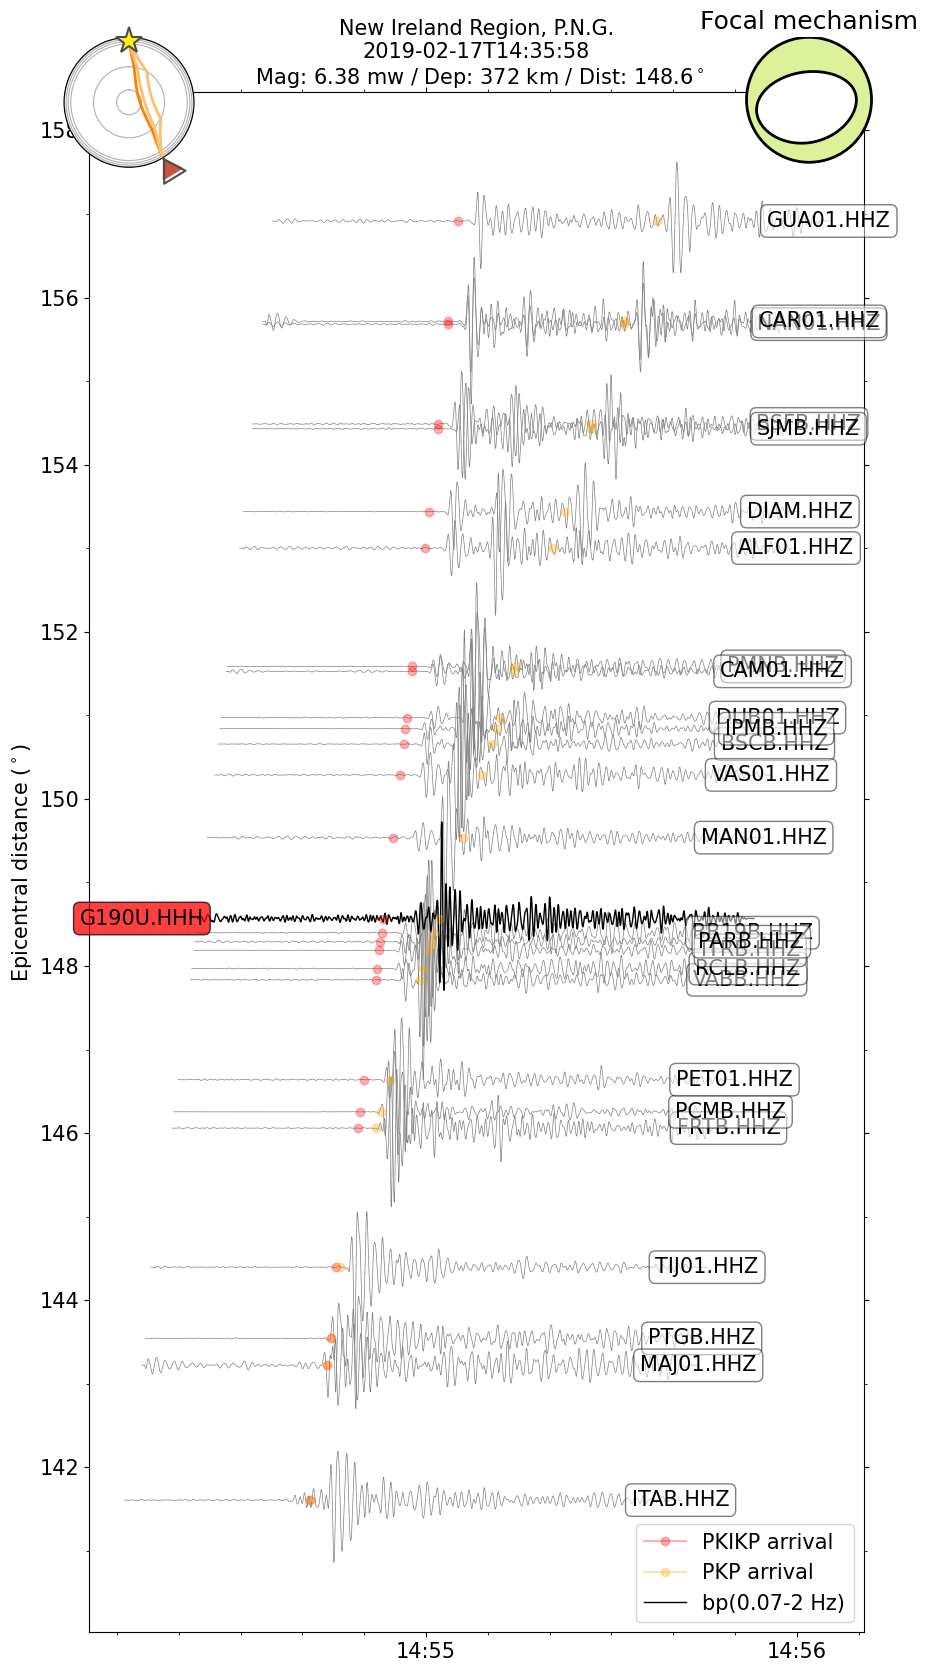

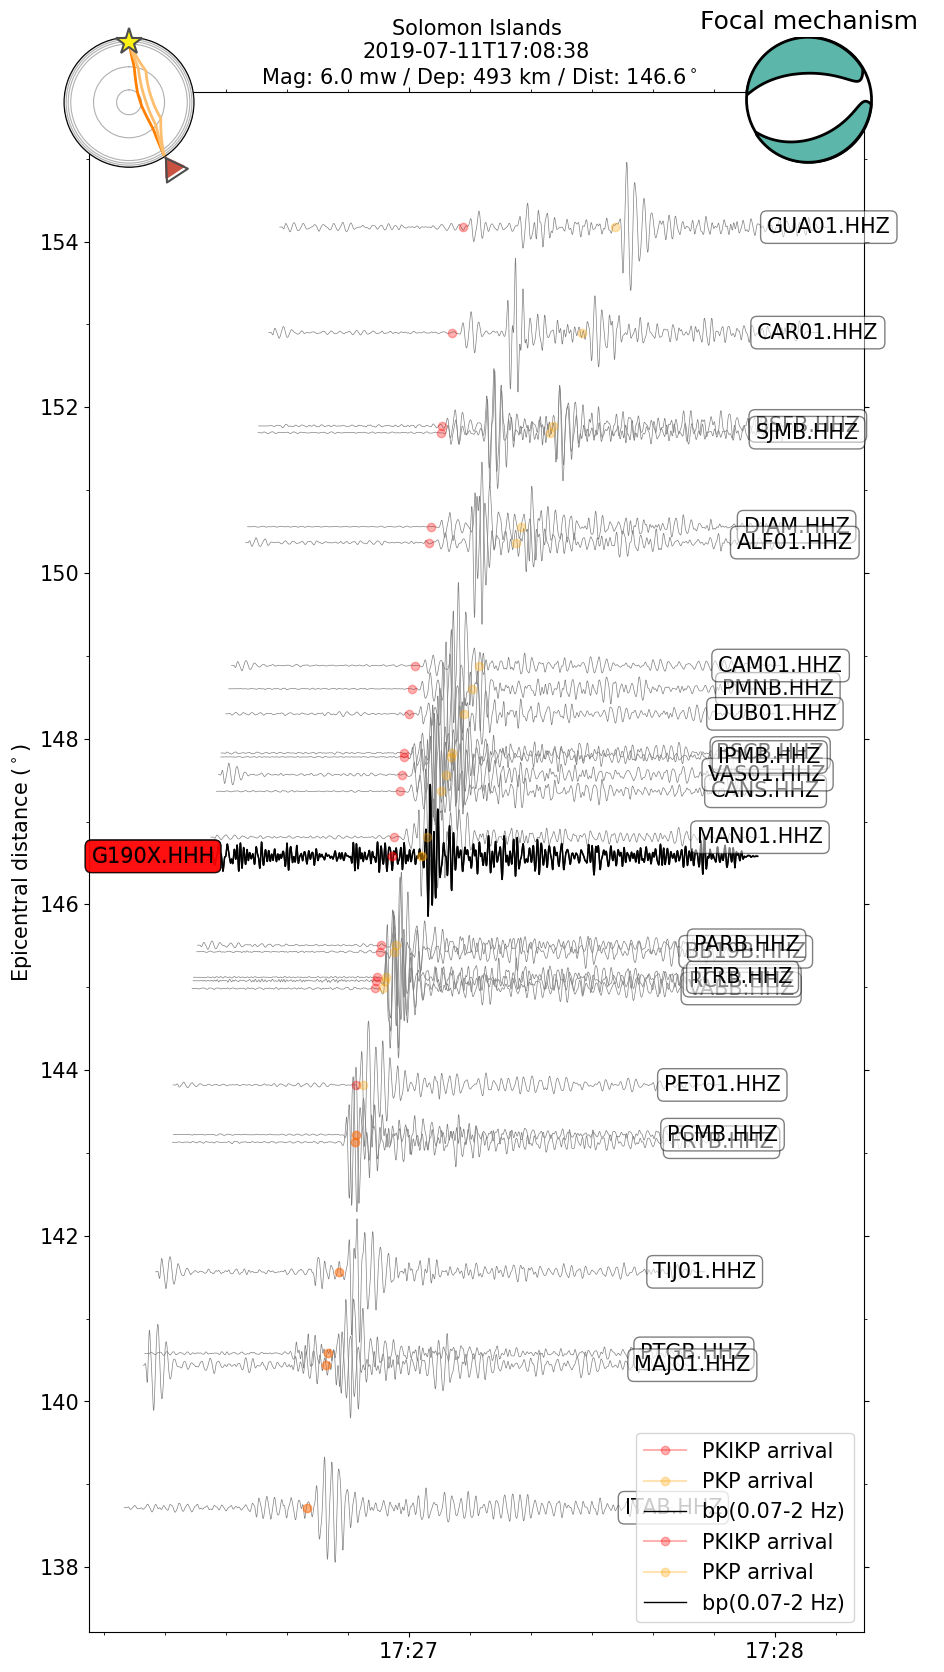

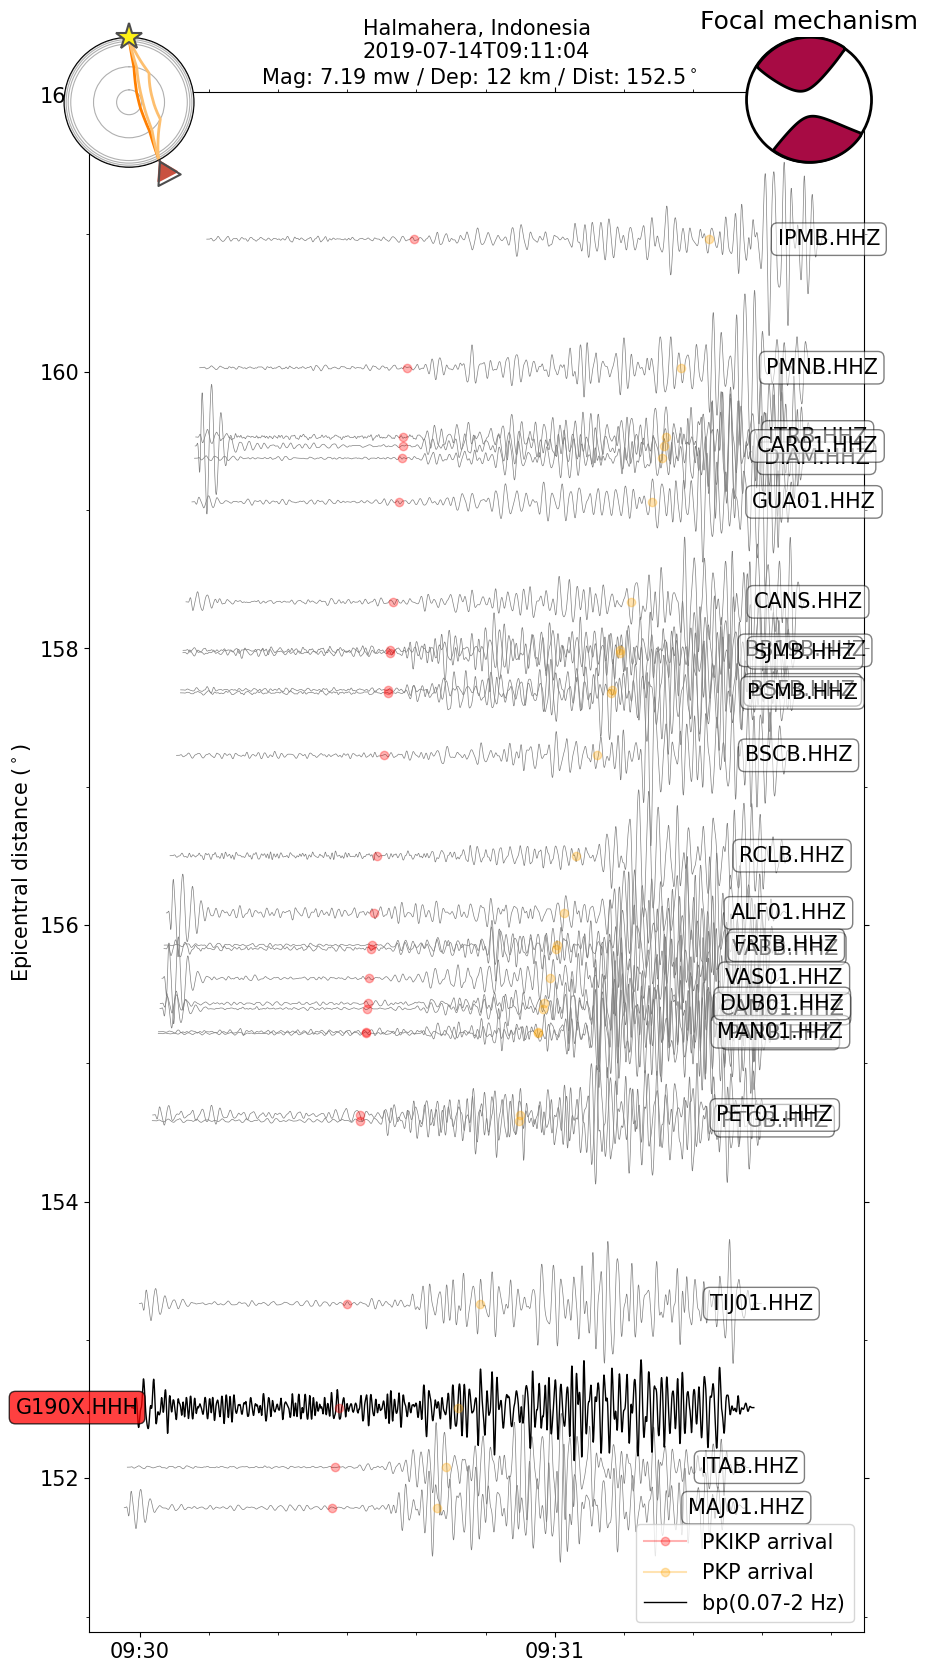

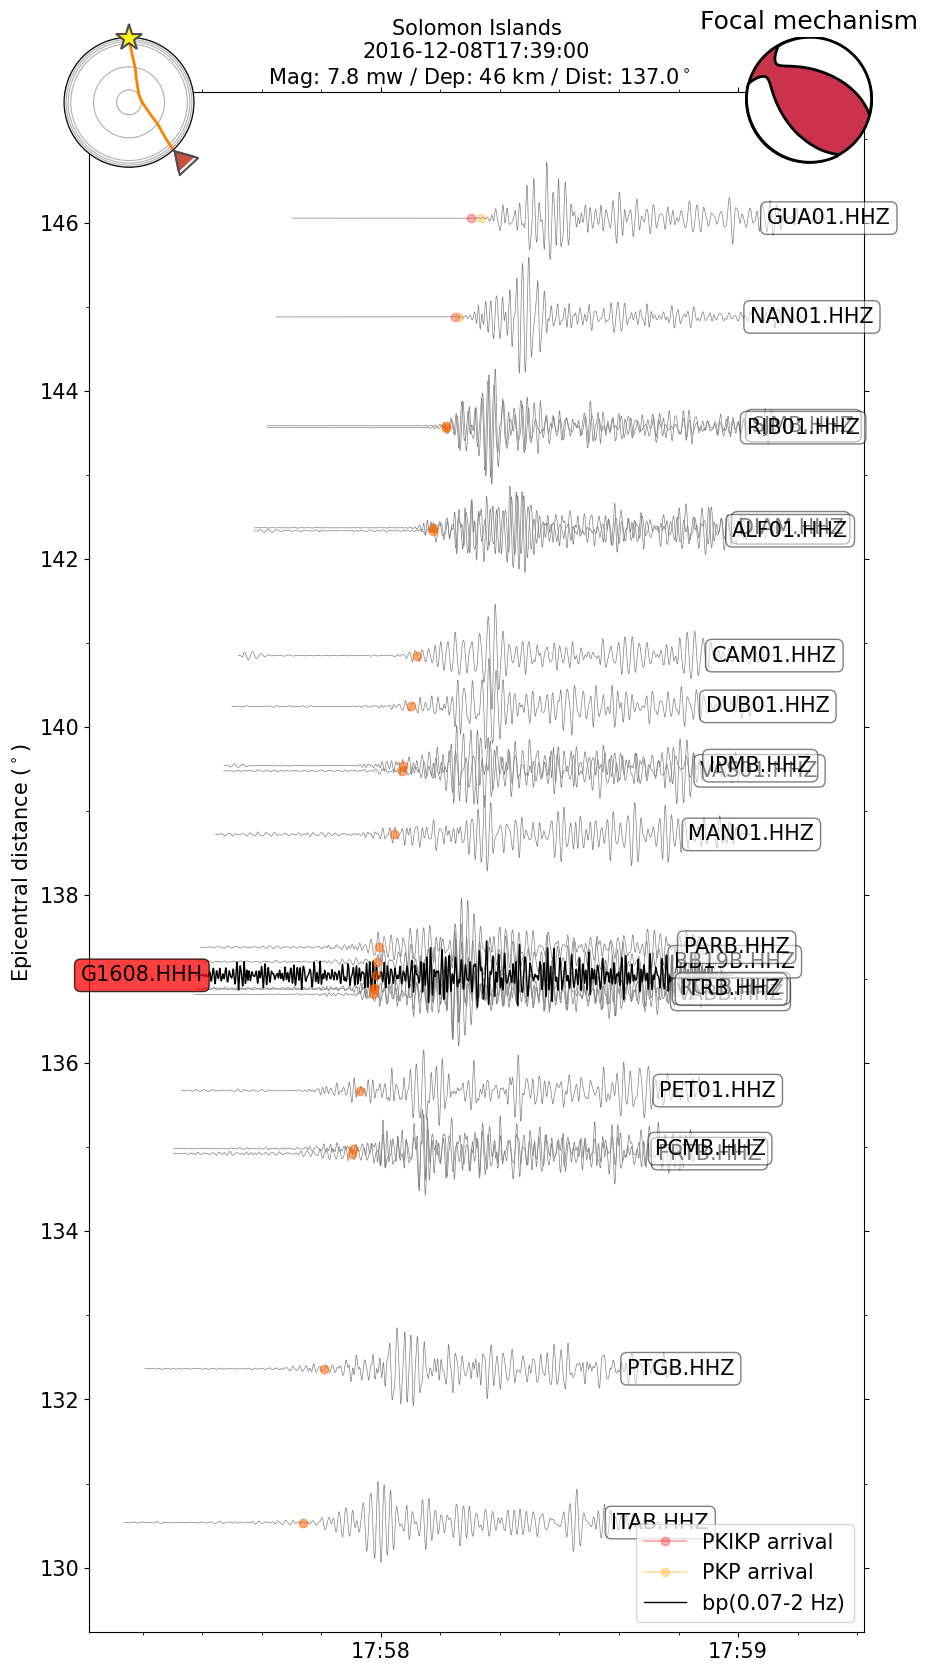

In [113]:
#########################################################################################################################################################
#Figure REGIONAL
# Setting: Global font size
mpl.rcParams.update({'font.size': 15})

for i in df.iterrows():

        glider = glob(EVENT_GLIDER+i[1]['filename_mseed'].split('.')[0]+'/'+i[1]['name_glider']+'/'+str(UTCDateTime(i[1]['ev_time']).year)+'/'+'{:03}'.format(UTCDateTime(i[1]['ev_time']).julday)+'/'+UTCDateTime(i[1]['ev_time']).strftime('%Y.%j.%H.%M.%S')+'*/*')
        rsbr = glob(EVENT_RSBR+'*/*/'+str(UTCDateTime(i[1]['ev_time']).year)+'/'+'{:03}'.format(UTCDateTime(i[1]['ev_time']).julday)+'/'+UTCDateTime(i[1]['ev_time']).strftime('%Y.%j.%H')+'*/*.Z')

        evt_time = [c.origins[-1].time for c in cat if c.event_descriptions[0].text == i[1]['ev_ID']][0]

        event = i[1]['ev_time']
        ev_lat = i[1]['ev_lat']
        ev_long = i[1]['ev_long']
        ev_depth = i[1]['ev_depth']
        magnitude = i[1]['magnitude']
        magnitude_type = i[1]['magnitude_type']
        time_ev = obspy.UTCDateTime(event)

        # set up the plot and create a GeoAxes:
        fig = plt.figure(figsize=(10,20))
        ax = fig.add_subplot()
        
        # ============= #
        # RSBR STATIONS
        # ============= #
        for st_file in rsbr:
            st_plot = obspy.read(st_file)[0]
            
            gcarc = st_plot.stats.sac.gcarc
    
            #Event time at each station
            #Calculating distance, azimuth and backazimuth
            model = TauPyModel(model='ak135')
            
            time_ev1 = obspy.UTCDateTime(evt_time)

            if i[1]['Phase'] == 'PKIKP' or i[1]['Phase'] == 'PKP':
                arrival = model.get_travel_times(source_depth_in_km=ev_depth,distance_in_degree=gcarc,phase_list=['PKIKP','PKP'])
                event_time = time_ev1+arrival[0].time
                event_time_PKP = time_ev1+arrival[-1].time
               
                ax.plot(event_time.matplotlib_date,gcarc,c='r',marker='o',alpha=0.3,zorder=10)
                ax.plot(event_time_PKP.matplotlib_date,gcarc,c='orange',marker='o',alpha=0.3,zorder=10)
            else:
                arrival = model.get_travel_times(source_depth_in_km=ev_depth,distance_in_degree=gcarc,phase_list=['P'])
                event_time = time_ev1+arrival[0].time                             
                
                ax.plot(event_time.matplotlib_date,gcarc,c='r',marker='o',alpha=0.3,zorder=10)
                
            st_plot.trim(event_time-30,event_time+60)
            if len(st_plot) > 0:
                st_plot.filter('bandpass',freqmin=0.7,freqmax=2, corners=4, zerophase=False)
                st_plot.taper(max_percentage=0.05, type='cosine')      
                st_plot.detrend('linear')
                st_plot.detrend('demean')
                               
                ax.plot(st_plot.times('matplotlib'),gcarc+preprocessing.normalize([st_plot.data])[0]*10,c='grey',ls='-',lw=0.5)
                ax.text(x=st_plot.times('matplotlib')[-1],y=st_plot.stats.sac.gcarc,s=st_plot.stats.station+'.'+st_plot.stats.channel,ha="center",va="center",bbox=dict(boxstyle="round",ec='k',fc='w',alpha=0.5))

    
        for st_file_glider in glider:
            st_plot_glider = obspy.read(st_file_glider)[0]
        
            gcarc_glider = st_plot_glider.stats.sac.gcarc
            dep_glider = st_plot_glider.stats.sac.stel
            
            #Event time at each station
            #Calculating distance, azimuth and backazimuth

            if i[1]['Phase'] == 'PKIKP' or i[1]['Phase'] == 'PKP':
                arrival = model.get_travel_times(source_depth_in_km=ev_depth,distance_in_degree=gcarc_glider,phase_list=['PKIKP','PKP'])
                event_time_glider = time_ev1+arrival[0].time
                event_time_glider_PKP = time_ev1+arrival[-1].time
                ax.plot(event_time_glider.matplotlib_date,gcarc_glider,c='r',marker='o',alpha=0.3,label='PKIKP arrival',zorder=10)
                ax.plot(event_time_glider_PKP.matplotlib_date,gcarc_glider,c='orange',marker='o',alpha=0.3,label='PKP arrival',zorder=10)
            else:
                arrival = model.get_travel_times(source_depth_in_km=ev_depth,distance_in_degree=gcarc_glider,phase_list=['P'])
                event_time_glider = time_ev1+arrival[0].time
                ax.plot(event_time_glider.matplotlib_date,gcarc_glider,c='r',marker='o',alpha=0.3,label='P arrival',zorder=10)

            
            st_plot_glider.trim(event_time_glider-30,event_time_glider+60)

            if len(st_plot_glider) > 0:
                st_plot_glider.filter('bandpass', freqmin=0.7,freqmax=2, corners=4, zerophase=False)
                st_plot_glider.taper(max_percentage=0.05, type='cosine')     
                st_plot_glider.detrend('linear')
                st_plot_glider.detrend('demean')
            
                ax.plot(st_plot_glider.times('matplotlib'),gcarc_glider+preprocessing.normalize([st_plot_glider.data])[0]*10,c='k',ls='-',lw=1,label='bp(0.07-2 Hz)')
                ax.text(x=st_plot_glider.times('matplotlib')[100],y=gcarc_glider,s=st_plot_glider.stats.station+'.'+st_plot_glider.stats.channel,ha="right",va="center",bbox=dict(boxstyle="round",ec='k',fc='r',alpha=0.75))

        ax.set_title(i[1]['local']+'\n'+time_ev.strftime('%Y-%m-%dT%H:%M:%S')+'\n Mag: '+str(magnitude)+' '+magnitude_type+' / Dep: '+str(round(ev_depth))+' km / Dist: '+str(round(gcarc_glider,1))+'$^\circ$',fontsize=15)
        ax.set_ylabel('Epicentral distance ($^\circ$)')
        ax.legend(loc='lower right')
        ax.xaxis.set_major_locator(mdates.SecondLocator(interval=60))
        ax.xaxis.set_minor_locator(mdates.SecondLocator(interval=10))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        ax.yaxis.set_major_locator(MultipleLocator(2))
        ax.yaxis.set_minor_locator(MultipleLocator(1))
        ax.xaxis.set_ticks_position('both')
        ax.yaxis.set_ticks_position('both')

        # ----------------------------------------------------------------------------------------------------------
        # focal mechanisms
        # ----------------------------------------------------------------------------------------------------------

        # Plotting: graphical representation of a focal mechanism (https://docs.obspy.org/packages/autogen/obspy.imaging.beachball.beachball.html)

        # Normalize event depth values between 0 and 600 km:
        min_val = 0
        max_val = 600
        normalized_values = [(x - min_val) / (max_val - min_val) for x in np.arange(min_val, max_val,10)]

        # Colormap "Plasma" for each value
        colors = [plt.cm.Spectral(value) for value in normalized_values]
                                                                        
        # Convert colors RGB to hexadecimal:
        hex_colors = [mcolors.rgb2hex(color) for color in colors]

        # Find the color for a given depth
        diff_ev_depth = [np.abs(numero - ev_depth) for numero in np.arange(min_val, max_val,10)]
                                        
        # Find the min index for a given depth
        index_min_ev_depth = diff_ev_depth.index(min(diff_ev_depth))
    
        # -------------------------
    
        newax = fig.add_axes([0.72, 0.72, 0.25,  0.25])
    
        moment_tensor = ast.literal_eval(i[1]['moment_tensor'])
        mrr = moment_tensor[0]
        mtt = moment_tensor[1]
        mpp = moment_tensor[2]
        mrt = moment_tensor[3]
        mrp = moment_tensor[4]
        mtp = moment_tensor[5]
        mt = [mrr, mtt, mpp, mrt, mrp, mtp]
    
        # Plotting the hexcolor
        bball = beach(fm=mt, xy=(0, 0.5),size=500, width=1, facecolor=hex_colors[index_min_ev_depth])
            
        # Configura os eixos e adiciona a coleção
        newax.add_collection(bball)
        newax.set_xlim(-1, 1)
        newax.set_ylim(-1, 1)
        newax.set_aspect('equal')
        newax.axis('off')
        newax.set_title('Focal mechanism')

        # ===========================================================
        # ray paths (https://docs.obspy.org/packages/obspy.taup.html)
        # ===========================================================
        
        # ---------------------------------------------------------------------------------------------------
        # Computing: The paths travelled by the rays to the receiver for a given phase and 1D velocity model 
                    
        arrivals_ray_path = model.get_ray_paths(source_depth_in_km=ev_depth, distance_in_degree=gcarc_glider, phase_list=['P','PKP','PKIKP'])

        # -------------------------
        # Plotting: axes parameters 
                                    
        ax_raypath = fig.add_axes([0.1, 0.81, 0.13,  0.13], projection='polar')
        arrivals_ray_path.plot_rays(ax=ax_raypath)
        ax_raypath.set_title('Ray path',y=1.08)
   
        # ----------------------------------------------------------------------------------------------------------
        # Saving figure
        os.makedirs(FOLDER_OUTPUT+'EVENTS/FIGURES/REGIONAL/',exist_ok=True)
        fig.savefig(FOLDER_OUTPUT+'EVENTS/FIGURES/REGIONAL/'+'event_mseed_'+time_ev.strftime('%Y-%m-%dT%H:%M:%S')+'_'+i[1]['ev_ID']+'.png',pad_inches=0.0,dpi=200)
        plt.close()


# LOCAL

In [137]:
local_event = glob(QUAKEXML_FOLDER+'event_2020_03_25_brazil.xml')[0]

In [139]:
evt = obspy.read_events(local_event)

In [144]:
evt[0].magnitudes[-1].mag

4.178979589

In [148]:
iag_catalogo_costa = pd.read_csv("/home/sysop/dados_posdoc/GLIDER_PETROBRAS/TERREMOTOS_SISBRA_2022/iag_catalogo_costa.csv")


In [156]:
evento_costa = iag_catalogo_costa[iag_catalogo_costa['evid'] == '"usp2020fyjb"']

In [157]:
evento_costa

evid               origin  longitude  latitude  depth  magnitude  \
5  "usp2020fyjb"  2020/03/25 11:30:39    -41.928   -24.543      0        4.2   

  magnitudet                  region      author mode  
5       "mb"  "South Atlantic Ocean"  "jroberto"    M

In [163]:
#########################################################################################################################################################
#Figure LOCAL
# Setting: Global font size
mpl.rcParams.update({'font.size': 15})

for ev in evento_costa.iterrows():

        #glider = glob(EVENT_GLIDER+i[1]['filename_mseed'].split('.')[0]+'/'+i[1]['name_glider']+'/'+str(UTCDateTime(i[1]['ev_time']).year)+'/'+'{:03}'.format(UTCDateTime(i[1]['ev_time']).julday)+'/'+UTCDateTime(i[1]['ev_time']).strftime('%Y.%j.%H.%M.%S')+'*/*')
        #rsbr = glob(EVENT_RSBR+'*/*/'+str(UTCDateTime(i[1]['origin']).year)+'/'+'{:03}'.format(UTCDateTime(i[1]['origin']).julday)+'/'+UTCDateTime(i[1]['origin']).strftime('%Y.%j.%H')+'*/*.Z')

        event = ev[-1]['origin']
        print(UTCDateTime(ev[-1]['origin']))

        ev_lat = ev[-1]['latitude']
        ev_long = ev[-1]['longitude']
        ev_depth = ev[-1]['depth']
        magnitude = ev[-1]['magnitude']
        magnitude_type = ev[-1]['magnitudet']
    
        time_ev = event

        # set up the plot and create a GeoAxes:
        fig = plt.figure(figsize=(10,20))
        ax = fig.add_subplot()
        
        # ============= #
        # RSBR STATIONS
        # ============= #
        for st_file in rsbr:
            st_plot = obspy.read(st_file)[0]
            
            gcarc = st_plot.stats.sac.gcarc
    
            #Event time at each station
            #Calculating distance, azimuth and backazimuth
            model = TauPyModel(model='ak135')
            
            if i[1]['Phase'] == 'PKIKP' or i[1]['Phase'] == 'PKP':
                arrival = model.get_travel_times(source_depth_in_km=ev_depth,distance_in_degree=gcarc,phase_list=['PKIKP','PKP'])
                event_time = time_ev+arrival[0].time
                event_time_PKP = time_ev+arrival[-1].time
               
                ax.plot(event_time.matplotlib_date,gcarc,c='r',marker='o',alpha=0.3,zorder=10)
                ax.plot(event_time_PKP.matplotlib_date,gcarc,c='orange',marker='o',alpha=0.3,zorder=10)
            else:
                arrival = model.get_travel_times(source_depth_in_km=ev_depth,distance_in_degree=gcarc,phase_list=['P'])
                event_time = time_ev+arrival[0].time                             
                
                ax.plot(event_time.matplotlib_date,gcarc,c='r',marker='o',alpha=0.3,zorder=10)
                
            st_plot.trim(event_time-30,event_time+60)
            if len(st_plot) > 0:
                st_plot.filter('bandpass',freqmin=0.7,freqmax=2, corners=4, zerophase=False)
                st_plot.taper(max_percentage=0.05, type='cosine')      
                st_plot.detrend('linear')
                st_plot.detrend('demean')
                               
                ax.plot(st_plot.times('matplotlib'),gcarc+preprocessing.normalize([st_plot.data])[0]*10,c='grey',ls='-',lw=0.5)
                ax.text(x=st_plot.times('matplotlib')[-1],y=st_plot.stats.sac.gcarc,s=st_plot.stats.station+'.'+st_plot.stats.channel,ha="center",va="center",bbox=dict(boxstyle="round",ec='k',fc='w',alpha=0.5))

    
        for st_file_glider in glider:
            st_plot_glider = obspy.read(st_file_glider)[0]
        
            gcarc_glider = st_plot_glider.stats.sac.gcarc
            dep_glider = st_plot_glider.stats.sac.stel
            
            #Event time at each station
            #Calculating distance, azimuth and backazimuth

            if i[1]['Phase'] == 'PKIKP' or i[1]['Phase'] == 'PKP':
                arrival = model.get_travel_times(source_depth_in_km=ev_depth,distance_in_degree=gcarc_glider,phase_list=['PKIKP','PKP'])
                event_time_glider = time_ev+arrival[0].time
                event_time_glider_PKP = time_ev+arrival[-1].time
                ax.plot(event_time_glider.matplotlib_date,gcarc_glider,c='r',marker='o',alpha=0.3,label='PKIKP arrival',zorder=10)
                ax.plot(event_time_glider_PKP.matplotlib_date,gcarc_glider,c='orange',marker='o',alpha=0.3,label='PKP arrival',zorder=10)

                # -----------------------------------------------------------------
                # Estimation: arrival time by CAKE (https://pyrocko.org/docs/current/apps/cake/index.html)
                # Cake is a command line tool contained in Pyrocko, which can solve some classical seismic ray theory problems for 1D layered earth models (layer cake models).
                    
                #command = 'cake arrivals --model='+MODEL_CAKE+' --sdepth='+str(ev_depth)+' --rdepth='+str(str(np.abs(dep_glider)/1000))+' --distances='+str(gcarc_glider)+' --degrees --classic="PKIKP","PKP"'
                #proc = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True,text=True)
                #(out, err) = proc.communicate()
                #results = out.splitlines()
                 
                  

                #if len(results) > 4:
                    #event_time_glider = time_ev+float(results[3].split(' ')[2])
                    #event_time_glider_PKP = time_ev+float(results[4].split(' ')[2])
                    #ax.plot(event_time_glider.matplotlib_date,gcarc_glider,c='r',marker='o',alpha=0.3,label='PKIKP arrival',zorder=10)
                    #ax.plot(event_time_glider_PKP.matplotlib_date,gcarc_glider,c='orange',marker='o',alpha=0.3,label='PKP arrival',zorder=10)
                
                #else:
                   #event_time_glider = time_ev1+float(results[3].split(' ')[2])
                    #ax.plot(event_time_glider.matplotlib_date,gcarc_glider,c='r',marker='o',alpha=0.3,label='PKIKP arrival',zorder=10)
       
            else:
                arrival = model.get_travel_times(source_depth_in_km=ev_depth,distance_in_degree=gcarc_glider,phase_list=['P'])
                event_time_glider = time_ev1+arrival[0].time
                ax.plot(event_time_glider.matplotlib_date,gcarc_glider,c='r',marker='o',alpha=0.3,label='P arrival',zorder=10)

            
                # -----------------------------------------------------------------
                # Estimation: arrival time by CAKE (https://pyrocko.org/docs/current/apps/cake/index.html)
                # Cake is a command line tool contained in Pyrocko, which can solve some classical seismic ray theory problems for 1D layered earth models (layer cake models).
                    
                #command = 'cake arrivals --model='+MODEL_CAKE+' --sdepth='+str(ev_depth)+' --rdepth='+str(str(np.abs(dep_glider)/1000))+' --distances='+str(gcarc_glider)+' --degrees --classic="P"'
                #proc = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True,text=True)
                #(out, err) = proc.communicate()
                #results = out.splitlines()

                #event_time_glider = time_ev1+float(results[3].split(' ')[2])
                #ax.plot(event_time_glider.matplotlib_date,gcarc_glider,c='r',marker='o',alpha=0.3,label='P arrival',zorder=10)

            st_plot_glider.trim(event_time_glider-30,event_time_glider+60)

            if len(st_plot_glider) > 0:
                st_plot_glider.filter('bandpass', freqmin=0.7,freqmax=2, corners=4, zerophase=False)
                st_plot_glider.taper(max_percentage=0.05, type='cosine')     
                st_plot_glider.detrend('linear')
                st_plot_glider.detrend('demean')
            
                ax.plot(st_plot_glider.times('matplotlib'),gcarc_glider+preprocessing.normalize([st_plot_glider.data])[0]*10,c='k',ls='-',lw=1,label='bp(0.07-2 Hz)')
                ax.text(x=st_plot_glider.times('matplotlib')[100],y=gcarc_glider,s=st_plot_glider.stats.station+'.'+st_plot_glider.stats.channel,ha="right",va="center",bbox=dict(boxstyle="round",ec='k',fc='r',alpha=0.75))

        ax.set_title(i[1]['local']+'\n'+time_ev.strftime('%Y-%m-%dT%H:%M:%S')+'\n Mag: '+str(magnitude)+' '+magnitude_type+' / Dep: '+str(round(ev_depth))+' km / Dist: '+str(round(gcarc_glider,1))+'$^\circ$',fontsize=15)
        ax.set_ylabel('Epicentral distance ($^\circ$)')
        ax.legend(loc='lower right')
        ax.xaxis.set_major_locator(mdates.SecondLocator(interval=60))
        ax.xaxis.set_minor_locator(mdates.SecondLocator(interval=10))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        ax.yaxis.set_major_locator(MultipleLocator(2))
        ax.yaxis.set_minor_locator(MultipleLocator(1))
        ax.xaxis.set_ticks_position('both')
        ax.yaxis.set_ticks_position('both')

        # ----------------------------------------------------------------------------------------------------------
        # focal mechanisms
        # ----------------------------------------------------------------------------------------------------------

        # Plotting: graphical representation of a focal mechanism (https://docs.obspy.org/packages/autogen/obspy.imaging.beachball.beachball.html)

        # Normalize event depth values between 0 and 600 km:
        min_val = 0
        max_val = 600
        normalized_values = [(x - min_val) / (max_val - min_val) for x in np.arange(min_val, max_val,10)]

        # Colormap "Plasma" for each value
        colors = [plt.cm.Spectral(value) for value in normalized_values]
                                                                        
        # Convert colors RGB to hexadecimal:
        hex_colors = [mcolors.rgb2hex(color) for color in colors]

        # Find the color for a given depth
        diff_ev_depth = [np.abs(numero - ev_depth) for numero in np.arange(min_val, max_val,10)]
                                        
        # Find the min index for a given depth
        index_min_ev_depth = diff_ev_depth.index(min(diff_ev_depth))
    
        # -------------------------
    
        newax = fig.add_axes([0.72, 0.72, 0.25,  0.25])
    
        moment_tensor = ast.literal_eval(i[1]['moment_tensor'])
        mrr = moment_tensor[0]
        mtt = moment_tensor[1]
        mpp = moment_tensor[2]
        mrt = moment_tensor[3]
        mrp = moment_tensor[4]
        mtp = moment_tensor[5]
        mt = [mrr, mtt, mpp, mrt, mrp, mtp]
    
        # Plotting the hexcolor
        bball = beach(fm=mt, xy=(0, 0.5),size=500, width=1, facecolor=hex_colors[index_min_ev_depth])
            
        # Configura os eixos e adiciona a coleção
        newax.add_collection(bball)
        newax.set_xlim(-1, 1)
        newax.set_ylim(-1, 1)
        newax.set_aspect('equal')
        newax.axis('off')
        newax.set_title('Focal mechanism')

        # ===========================================================
        # ray paths (https://docs.obspy.org/packages/obspy.taup.html)
        # ===========================================================
        
        # ---------------------------------------------------------------------------------------------------
        # Computing: The paths travelled by the rays to the receiver for a given phase and 1D velocity model 
                    
        arrivals_ray_path = model.get_ray_paths(source_depth_in_km=ev_depth, distance_in_degree=gcarc_glider, phase_list=['P','PKP','PKIKP'])

        # -------------------------
        # Plotting: axes parameters 
                                    
        ax_raypath = fig.add_axes([0.1, 0.81, 0.13,  0.13], projection='polar')
        arrivals_ray_path.plot_rays(ax=ax_raypath)
        ax_raypath.set_title('Ray path',y=1.08)
   
        # ----------------------------------------------------------------------------------------------------------
        # Saving figure
        os.makedirs(FOLDER_OUTPUT+'EVENTS/FIGURES/REGIONAL/',exist_ok=True)
        fig.savefig(FOLDER_OUTPUT+'EVENTS/FIGURES/REGIONAL/'+'event_mseed_'+time_ev.strftime('%Y-%m-%dT%H:%M:%S')+'_'+i[1]['ev_ID']+'.png',pad_inches=0.0,dpi=200)
        plt.close()
        '''


2020-03-25T11:30:39.000000Z
